# LSTM

#### Imports

In [213]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Dict
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error


### Load Data

In [215]:
df = pd.read_csv("swift_creek_usgs_data_2020_2024.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
df

Discharge (cfs)  Water Temperature (C)  pH (std units)  \
DateTime                                                                      
2020-01-01 00:00:00              NaN                    NaN             NaN   
2020-01-01 01:00:00             96.0                   12.2             7.3   
2020-01-01 02:00:00             93.0                   12.2             7.3   
2020-01-01 03:00:00             93.0                   12.2             7.3   
2020-01-01 04:00:00             90.0                   12.2             7.3   
...                              ...                    ...             ...   
2024-12-31 19:00:00            260.0                   18.0             7.4   
2024-12-31 20:00:00            255.0                   17.6             7.4   
2024-12-31 21:00:00            248.0                   17.2             7.4   
2024-12-31 22:00:00            243.0                   16.9             7.4   
2024-12-31 23:00:00            236.0                   16.6             7.4   

                     Dissolved Oxygen (mg/L)  Specific Conductance (uS/cm)  \
DateTime                                                                     
2020-01-01 00:00:00                      NaN                           NaN   
2020-01-01 01:00:00                      9.8                         438.0   
2020-01-01 02:00:00                      9.8                         439.0   
2020-01-01 03:00:00                      9.8                         440.0   
2020-01-01 04:00:00                      9.8                         440.0   
...                                      ...                           ...   
2024-12-31 19:00:00                      8.6                         234.0   
2024-12-31 20:00:00                      8.6                         238.0   
2024-12-31 21:00:00                      8.6                         240.0   
2024-12-31 22:00:00                      8.7                         245.0   
2024-12-31 23:00:00                      8.7                         246.0   

                     Turbidity (NTU)  Total Organic Carbon (mg/L)  \
DateTime                                                            
2020-01-01 00:00:00              NaN                          NaN   
2020-01-01 01:00:00             39.0                         11.0   
2020-01-01 02:00:00             46.0                         12.0   
2020-01-01 03:00:00             39.0                         11.0   
2020-01-01 04:00:00             40.0                         11.0   
...                              ...                          ...   
2024-12-31 19:00:00             99.0                         14.0   
2024-12-31 20:00:00             95.0                         14.0   
2024-12-31 21:00:00             93.0                         14.0   
2024-12-31 22:00:00             92.0                         14.0   
2024-12-31 23:00:00             89.0                         14.0   

                     Nitrate + Nitrite (mg/L)  Total Phosphorus (mg/L)  \
DateTime                                                                 
2020-01-01 00:00:00                       NaN                      NaN   
2020-01-01 01:00:00                      3.03                    0.911   
2020-01-01 02:00:00                      3.05                    0.938   
2020-01-01 03:00:00                      3.06                    0.916   
2020-01-01 04:00:00                      3.07                    0.918   
...                                       ...                      ...   
2024-12-31 19:00:00                      1.05                    0.483   
2024-12-31 20:00:00                      1.08                    0.490   
2024-12-31 21:00:00                      1.09                    0.493   
2024-12-31 22:00:00                      1.13                    0.505   
2024-12-31 23:00:00                      1.14                    0.505   

                     Precipitation 1hr (in)  
DateTime                                     
2020-01-01 00:00:00      

### Create Dataset Class

In [216]:
def temporal_splits(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    df = df.sort_index()
    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex (hourly).")
    # Interpolate missing hours (optional): reindex to full hourly range between min/max
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="h")
    df = df.reindex(full_idx)
    # Simple missing-value handling -- fill/interpolate (you can swap strategies)
    df = df.interpolate(method='time').ffill().bfill()
    
    train = df.loc['2020-01-01':'2023-12-31 23:00:00']
    val   = df.loc['2024-01-01':'2024-06-30 23:00:00']
    test  = df.loc['2024-07-01':'2024-12-31 23:00:00']
    return {"train": train, "val": val, "test": test}

# ---------------------------
# Dataset class - creates sliding windows but only from each split separately
# ---------------------------
class SlidingWindowDataset(Dataset):
    def __init__(self, df: pd.DataFrame, input_cols, target_col: str, 
                 input_len: int = 168, out_len: int = 24):
        """
        df: DataFrame containing contiguous hourly data for the split
        input_cols: list of columns used as features (all params)
        target_col: name of column to forecast
        """
        self.input_len = input_len
        self.out_len = out_len
        self.input_cols = input_cols
        self.target_col = target_col
        arr_x = df[input_cols].values.astype(np.float32)
        arr_y = df[target_col].values.astype(np.float32)
        N = len(df)
        self.X = []
        self.Y = []
        # build windows (no crossing the split boundary because df is per-split)
        for i in range(0, N - (input_len + out_len) + 1):
            x = arr_x[i : i + input_len]
            y = arr_y[i + input_len : i + input_len + out_len]
            self.X.append(x)
            self.Y.append(y)
        self.X = np.stack(self.X) if len(self.X) > 0 else np.empty((0, input_len, len(input_cols)), dtype=np.float32)
        self.Y = np.stack(self.Y) if len(self.Y) > 0 else np.empty((0, out_len), dtype=np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


### Create LSTM Model

In [217]:
class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, out_len=24, dropout=0.2):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        # map hidden state to output sequence (we'll use the last hidden state)
        self.fc = nn.Linear(hidden_size, out_len)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        output, (h_n, c_n) = self.lstm(x)  # h_n shape: (num_layers, batch, hidden)
        # take last layer hidden state
        last_hidden = h_n[-1]  # (batch, hidden)
        out = self.fc(last_hidden)  # (batch, out_len)
        return out



### Create Train Loop

In [218]:
def train_model_for_target(
    df: pd.DataFrame,
    target_col: str,
    input_len: int = 168,
    out_len: int = 24,
    batch_size: int = 64,
    n_epochs: int = 50,
    lr: float = 1e-3,
    hidden_size: int = 128,
    num_layers: int = 2,
    device: str = None,
    verbose: bool = True,
    patience: int = 6
) -> Dict:
    """
    df: full DataFrame (hourly) with datetime index and all vars
    target_col: name of column to predict (string)
    returns dict with model, scalers, history, test metrics, predictions
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    splits = temporal_splits(df)
    # Validate presence of target in splits
    if splits['train'].shape[0] == 0:
        raise ValueError("Training split is empty. Check your DataFrame date coverage.")
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    input_cols = list(df.columns)  # use all columns
    # Fit scalers on TRAIN only (prevent leakage)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # reshape train features for scaler fit
    X_train_2d = splits['train'][input_cols].values.reshape(-1, len(input_cols))
    X_scaler.fit(X_train_2d)
    y_train_1d = splits['train'][target_col].values.reshape(-1, 1)
    y_scaler.fit(y_train_1d)

    # Apply scalers to each split
    def scale_df(split_df):
        Xs = X_scaler.transform(split_df[input_cols].values.reshape(-1, len(input_cols))).reshape(len(split_df), len(input_cols))
        # convert back to DataFrame to keep index alignment
        X_df = pd.DataFrame(Xs, index=split_df.index, columns=input_cols)
        y = y_scaler.transform(split_df[[target_col]].values).ravel()
        res_df = X_df.copy()
        res_df[target_col] = y
        return res_df

    train_scaled = scale_df(splits['train'])
    val_scaled   = scale_df(splits['val'])
    test_scaled  = scale_df(splits['test'])

    # Prepare datasets
    train_ds = SlidingWindowDataset(train_scaled, input_cols, target_col, input_len=input_len, out_len=out_len)
    val_ds   = SlidingWindowDataset(val_scaled, input_cols, target_col, input_len=input_len, out_len=out_len)
    test_ds  = SlidingWindowDataset(test_scaled, input_cols, target_col, input_len=input_len, out_len=out_len)

    if len(train_ds) == 0:
        raise ValueError("No training windows were created. Check your input_len/out_len and training period coverage.")

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    # Model
    model = LSTMForecaster(n_features=len(input_cols), hidden_size=hidden_size, num_layers=num_layers, out_len=out_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Early stopping
    best_val = float('inf')
    best_state = None
    wait = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)  # shape (B, seq, n_features)
            yb = yb.to(device)  # shape (B, out_len)
            optimizer.zero_grad()
            preds = model(xb)  # (B, out_len)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        train_loss = float(np.mean(train_losses)) if train_losses else 0.0

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())
        val_loss = float(np.mean(val_losses)) if val_losses else 0.0

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if verbose:
            print(f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

        # early stopping
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                if verbose:
                    print(f"Early stopping after {epoch} epochs (patience={patience}). Best val_loss={best_val:.6f}")
                break

    # load best state
    if best_state is not None:
        model.load_state_dict(best_state)

    # Evaluate on test set and return predictions (inverse scaled)
    model.eval()
    all_preds = []
    all_truth = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()  # scaled
            all_preds.append(preds)
            all_truth.append(yb.numpy())
    if len(all_preds) == 0:
        test_preds = np.empty((0, out_len))
        test_truth = np.empty((0, out_len))
    else:
        test_preds = np.vstack(all_preds)
        test_truth = np.vstack(all_truth)

    # Inverse transform target scaling
    # y_scaler was fit on shape (n,1), so transform needs shape (-1,1)
    def inv_y(arr):
        flat = arr.reshape(-1, 1)
        inv = y_scaler.inverse_transform(flat).reshape(arr.shape)
        return inv

    test_preds_inv = inv_y(test_preds)
    test_truth_inv = inv_y(test_truth)

    # Metrics (per sample then averaged)
    r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
    mae = mean_absolute_error(test_truth_inv,test_preds_inv)
    rmse = root_mean_squared_error(test_truth_inv,test_preds_inv)
    mse = mean_squared_error(test_truth_inv,test_preds_inv)
    r2 = r2_score(test_truth_inv,test_preds_inv)
    metrics = {"mae": float(mae), "rmse": float(rmse), "mse":float(mse),"r2":float(r2), "n_samples": test_preds_inv.shape[0]}

    result = {
        "model": model,
        "input_cols": input_cols,
        "target_col": target_col,
        "X_scaler": X_scaler,
        "y_scaler": y_scaler,
        "history": history,
        "metrics": metrics,
        "test_preds": test_preds_inv,
        "test_truth": test_truth_inv,
        "test_index": None,  # If the user wants the timestamps corresponding to each sample, we can compute them
        "device": device,
    }

    # Optionally: compute timestamps for test windows (start index for each window in test data)
    # We'll compute the datetime index of the target window start for each sample
    if len(test_ds) > 0:
        test_idx = []
        # test_scaled has same index as test split
        test_index_values = test_scaled.index
        N = len(test_index_values)
        # windows start at positions 0..N-input_len-out_len
        for i in range(0, N - (input_len + out_len) + 1):
            # store the index of the first forecasted timestamp (i + input_len)
            ts = test_index_values[i + input_len]
            test_idx.append(ts)
        result['test_index'] = pd.DatetimeIndex(test_idx)

    if verbose:
        print("Test metrics:", metrics)
    result['full_df'] = df
    return result


## Run Model

In [219]:
df.columns

Index(['Discharge (cfs)', 'Water Temperature (C)', 'pH (std units)',
       'Dissolved Oxygen (mg/L)', 'Specific Conductance (uS/cm)',
       'Turbidity (NTU)', 'Total Organic Carbon (mg/L)',
       'Nitrate + Nitrite (mg/L)', 'Total Phosphorus (mg/L)',
       'Precipitation 1hr (in)'],
      dtype='object')

In [220]:
target_column = "Water Temperature (C)"

In [221]:
temp_data = train_model_for_target(df,
                                    target_col=target_column,
                                    input_len=168, # one week
                                    out_len=24, # one day
                                    batch_size=64,
                                    n_epochs=50,
                                    lr=1e-3,
                                    hidden_size=64,
                                    num_layers=2,
                                    device=None,
                                    verbose=True,
                                    patience=6)

Epoch 001 | train_loss=0.108086 | val_loss=0.043666
Epoch 002 | train_loss=0.041358 | val_loss=0.040300
Epoch 003 | train_loss=0.037299 | val_loss=0.037442
Epoch 004 | train_loss=0.034633 | val_loss=0.037320
Epoch 005 | train_loss=0.032975 | val_loss=0.037859
Epoch 006 | train_loss=0.031715 | val_loss=0.036730
Epoch 007 | train_loss=0.030485 | val_loss=0.036578
Epoch 008 | train_loss=0.029006 | val_loss=0.037344
Epoch 009 | train_loss=0.027820 | val_loss=0.035202
Epoch 010 | train_loss=0.026468 | val_loss=0.038634
Epoch 011 | train_loss=0.025153 | val_loss=0.036411
Epoch 012 | train_loss=0.023831 | val_loss=0.040673
Epoch 013 | train_loss=0.022838 | val_loss=0.042021
Epoch 014 | train_loss=0.021320 | val_loss=0.038369
Epoch 015 | train_loss=0.020237 | val_loss=0.038754
Early stopping after 15 epochs (patience=6). Best val_loss=0.035202
Test metrics: {'mae': 0.9771688580513, 'rmse': 1.2892705202102661, 'mse': 1.776875615119934, 'r2': 0.947144091129303, 'n_samples': 4225}


## Grid Search

In [186]:
import pandas as pd

def tune_single_hyperparam(
        df,
        target_column,
        param_name,
        param_values,
        *,
        # Default hyperparameters
        input_len=168, 
        out_len=24,
        batch_size=64,
        n_epochs=50,
        lr=1e-3,
        hidden_size=64,
        num_layers=2,
        device=None,
        verbose=True,
        patience=6,
        # Function used to train
        train_fn=train_model_for_target
    ):
    """
    Tune a single hyperparameter at a time. All other hyperparameters remain fixed.

    param_name:   str, name of parameter to tune (e.g., "lr", "hidden_size")
    param_values: list, values to test for that parameter

    Returns:
        DataFrame summarizing model performance for each tested value.
    """
    
    results = []

    for value in param_values:
        if verbose:
            print(f"\n=== Testing {param_name} = {value} ===")

        # Copy default params
        params = {
            "input_len": input_len,
            "out_len": out_len,
            "batch_size": batch_size,
            "n_epochs": n_epochs,
            "lr": lr,
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "device": device,
            "verbose": verbose,
            "patience": patience,
        }

        # Replace only the hyperparameter we're tuning
        params[param_name] = value

        # Train model
        result = train_fn(
            df,
            target_col=target_column,
            **params
        )

        # Store results (add param value)
        result_entry = {"param_name": param_name, "param_value": value}

        # Merge returned metrics into a single flat dict
        if isinstance(result, dict):
            result_entry.update(result)
        else:
            result_entry["result"] = result

        results.append(result_entry)

    return pd.DataFrame(results)


In [ ]:
# results = tune_single_hyperparam(
#     df,
#     target_column="Water Temperature (C)",
#     param_name="lr",
#     param_values=[1e-4, 1e-3, 1e-2]
# )
# print(results)



=== Testing lr = 0.0001 ===
Epoch 001 | train_loss=0.356221 | val_loss=0.100520
Epoch 002 | train_loss=0.098642 | val_loss=0.095679
Epoch 003 | train_loss=0.086373 | val_loss=0.078696
Epoch 004 | train_loss=0.061486 | val_loss=0.059132
Epoch 005 | train_loss=0.049015 | val_loss=0.054015
Epoch 006 | train_loss=0.046329 | val_loss=0.050762
Epoch 007 | train_loss=0.044411 | val_loss=0.050348
Epoch 008 | train_loss=0.042996 | val_loss=0.046458
Epoch 009 | train_loss=0.041468 | val_loss=0.047601
Epoch 010 | train_loss=0.040219 | val_loss=0.044222
Epoch 011 | train_loss=0.038965 | val_loss=0.043634
Epoch 012 | train_loss=0.038133 | val_loss=0.043284
Epoch 013 | train_loss=0.037295 | val_loss=0.041214
Epoch 014 | train_loss=0.036617 | val_loss=0.040561
Epoch 015 | train_loss=0.035953 | val_loss=0.040027
Epoch 016 | train_loss=0.035456 | val_loss=0.040466
Epoch 017 | train_loss=0.034907 | val_loss=0.041390
Epoch 018 | train_loss=0.034653 | val_loss=0.039580
Epoch 019 | train_loss=0.034072 | v

In [ ]:
# results['metrics'][0]['r2'], results['metrics'][1]['r2'], results['metrics'][2]['r2']

(0.9521818161010742, 0.9536862373352051, 0.9221806526184082)

## Plotting Functions

In [239]:
import datetime

In [289]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_week_window(res, day):
    """
    Visualize model forecast for a chosen day + the actual week leading up.
    
    Parameters
    ----------
    res : dict
        Output dictionary from train_model_for_target()
    day : str or datetime
        The day you want to visualize (the forecast day)
    """
    target = res["target_col"]
    df = res["X_scaler"].mean_  # dummy line to show res exists

    # Extract required model outputs
    test_idx = res["test_index"]                  # timestamps for each forecast
    preds = res["test_preds"]                     # shape (N, 24)
    truth = res["test_truth"]                     # shape (N, 24)

    df_full = res["full_df"] if "full_df" in res else None
    if df_full is None:
        raise ValueError("To use plot_week_window, store original df in res. Modify training function to add res['full_df']=df.")

    # Convert day input
    day = pd.to_datetime(day)
    # Find matching forecast sample (model predicts starting at 'day')
    try:
        idx = np.where(test_idx == day)[0][0]
    except:
        raise ValueError(f"Day {day.date()} is not a valid forecast day in the test set.")

    pred_day_values = preds[idx]
    true_day_values = truth[idx]

    # Build time axis for the 24-hour prediction
    pred_times = pd.date_range(day, periods=24, freq="h")

    # One week of historical actual data
    week_start = day - pd.Timedelta(days=7)
    week_data = df_full[target].loc[week_start:day]

    # --- Plotting ---
    plt.figure(figsize=(12,6))

    # Plot historical week
    plt.plot(week_data.index, week_data.values, label="Previous 7 days (actual)", color="blue")

    # Plot 24-hour prediction
    plt.plot(pred_times, pred_day_values, label="Forecast (next 24h)", color="red")

    # Plot true 24-hour values
    plt.plot(pred_times, true_day_values, label="True values (next 24h)", color="green", linestyle="--")
    r2 = r2_score(true_day_values,pred_day_values)
    print(f"R2: {r2:.4f}")
    plt.axvline(day, color="black", linestyle=":", label="Forecast start")
    plt.title(f"Week Before + 24-Hour Forecast for {day.date()}")
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


R2: 0.9000


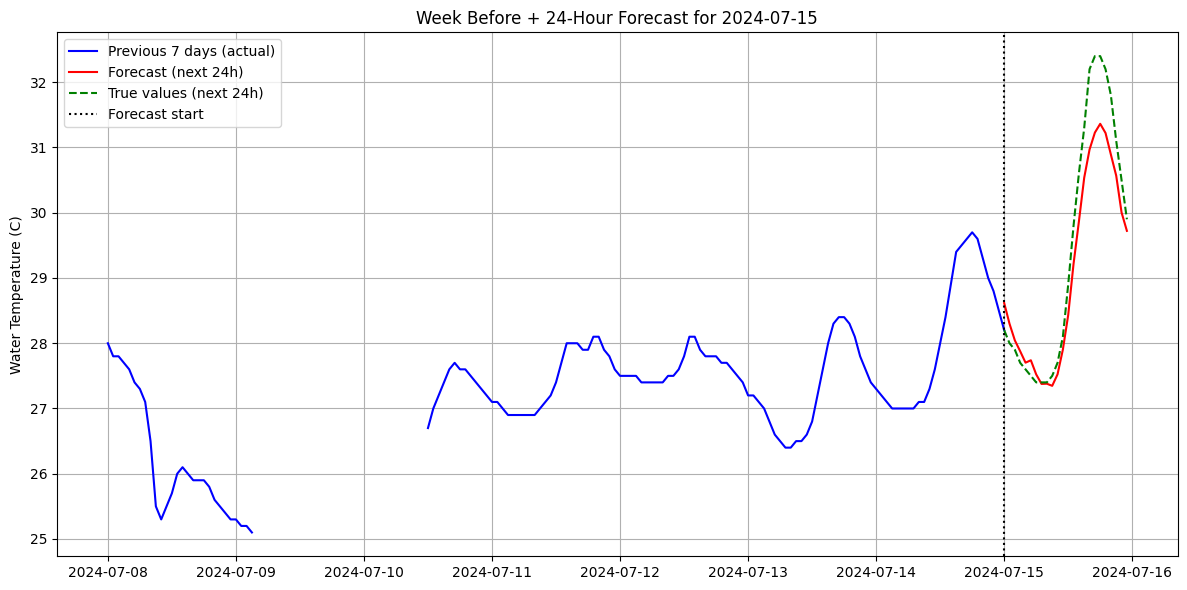

In [290]:
plot_week_window(temp_data, "2024-07-15")

R2: 0.2239


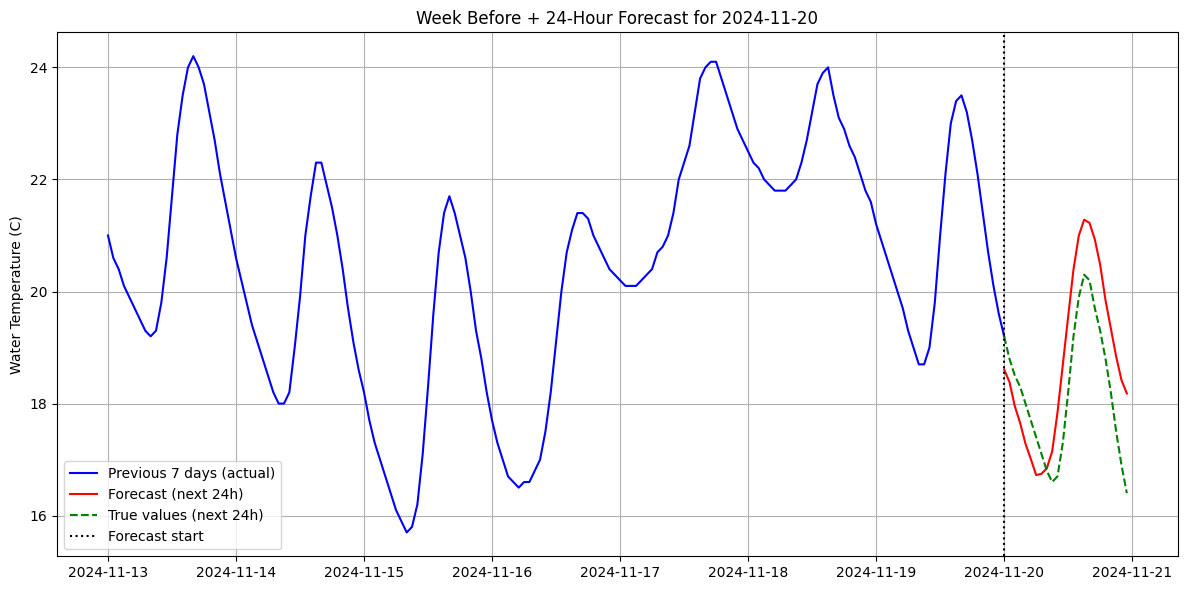

In [291]:
plot_week_window(temp_data, "2024-11-20")

R2: 0.7971


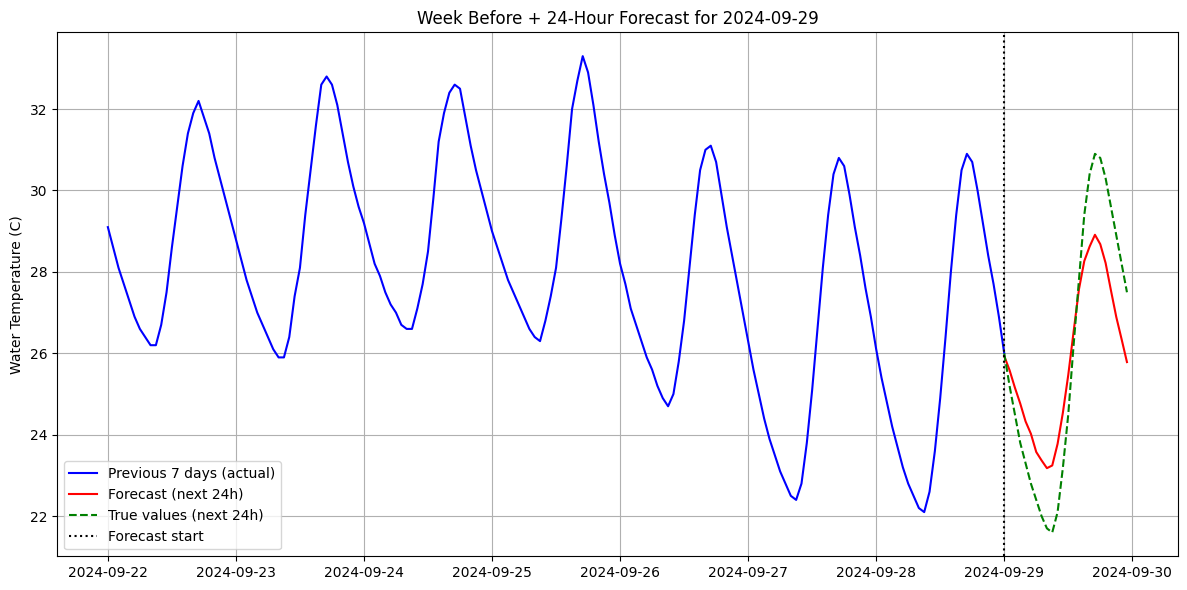

In [295]:
plot_week_window(temp_data, "2024-9-29")

In [387]:
def plot_test_daily(res, hr_out=0):
    """
    Plot full test set:
    - Each day's 24-hour prediction averaged to 1 value
    - Each day's true 24-hour target averaged to 1 value
    """
    target = res["target_col"]
    
    test_idx = res["test_index"]        # timestamps for each forecast
    preds = res["test_preds"]           # shape (N, 24)
    truth = res["test_truth"]           # shape (N, 24)
    print(len(test_idx))
    # Apply rolling average of roll hours
    # pred_daily = pd.DataFrame(preds.flatten()).rolling(window=roll).mean()
    # true_daily = pd.DataFrame(truth.flatten()).rolling(window=roll).mean()
    pred_daily = pd.DataFrame(preds[:,hr_out],index=test_idx).rolling(24).mean()
    true_daily = pd.DataFrame(truth[:,hr_out],index=test_idx).shift(hr_out).rolling(24).mean()
    # print(true_daily.sum())
    # return pd.DataFrame(preds[:,0])
    # --- Plot ---
    plt.figure(figsize=(12,6))
    plt.plot(true_daily, label="True (Rolling)", color="green",linewidth=2)
    plt.plot(pred_daily, label="Predicted (Rolling)", color="red", alpha=0.7,linewidth=2)
    # r2 = r2_score(true_daily.dropna(),pred_daily.dropna())
    # print(f"Rolling R2: {r2:.4f}")
    plt.title(f"Prediction of {target} at {hr_out+1} hours before")
    plt.ylabel(target)
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


4225


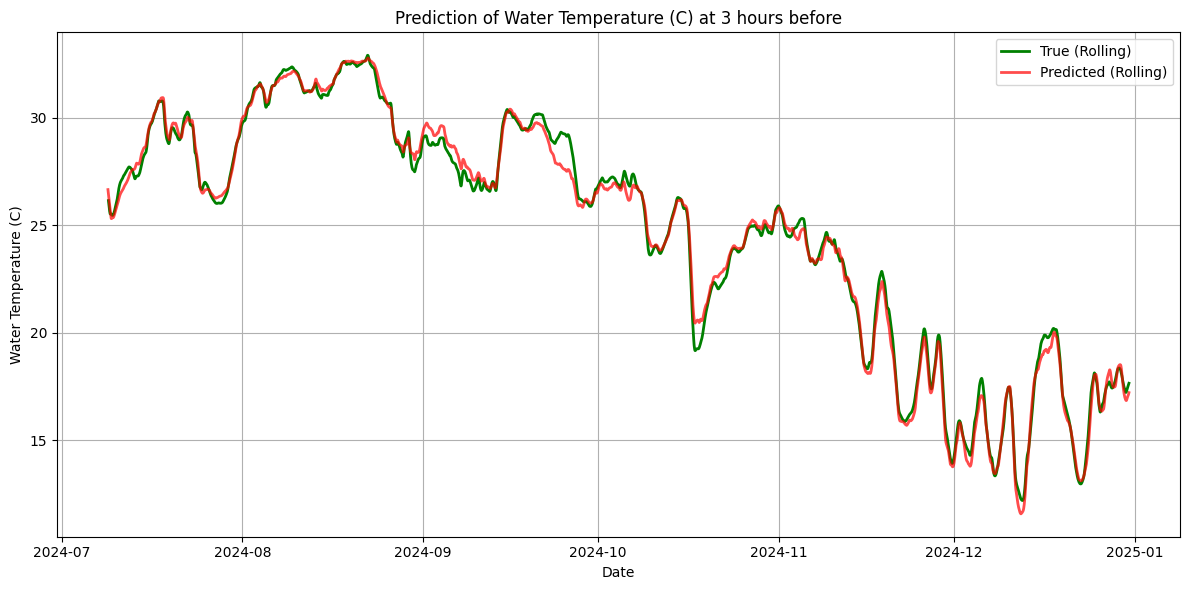

In [391]:
plot_test_daily(temp_data,hr_out=2)

In [426]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd

def plot_all_predictions(res):
    """
    Plot:
    - True daily rolling (24-hour)
    - 24 rolling curves for each forecast horizon (0–23 hours ahead)
    - Colorbar indicating forecast horizon
    """

    target = res["target_col"]
    
    test_idx = res["test_index"]        # index of prediction times
    preds = res["test_preds"]           # shape (N, 24)
    truth = res["test_truth"]           # shape (N, 24)

    # True rolling using the first hour of each truth window
    true_daily = pd.Series(truth[:,0], index=test_idx).rolling(24).mean()

    # Color mapping for horizon
    cmap = cm.viridis
    norm = colors.Normalize(vmin=1, vmax=24)

    # -----------------------------
    # Create figure + axis explicitly
    # -----------------------------
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot true rolling

    # Plot each horizon with rolling
    for h in range(24):
        series = pd.Series(preds[:, h], index=test_idx).rolling(24).mean()
        ax.plot(series, color=cmap(norm(h)), alpha=0.7)

    # Create ScalarMappable for colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # -----------------------------
    # FIX: Explicitly attach colorbar to `ax`
    # -----------------------------
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Forecast Horizon (hours ahead)", fontsize=12)
    ax.plot(true_daily, color="black", linewidth=2.0, label="True (24h rolling)")

    # Layout
    ax.set_title(f"24-hour Rolling Forecast Performance: {target}", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel(target)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    plt.show()


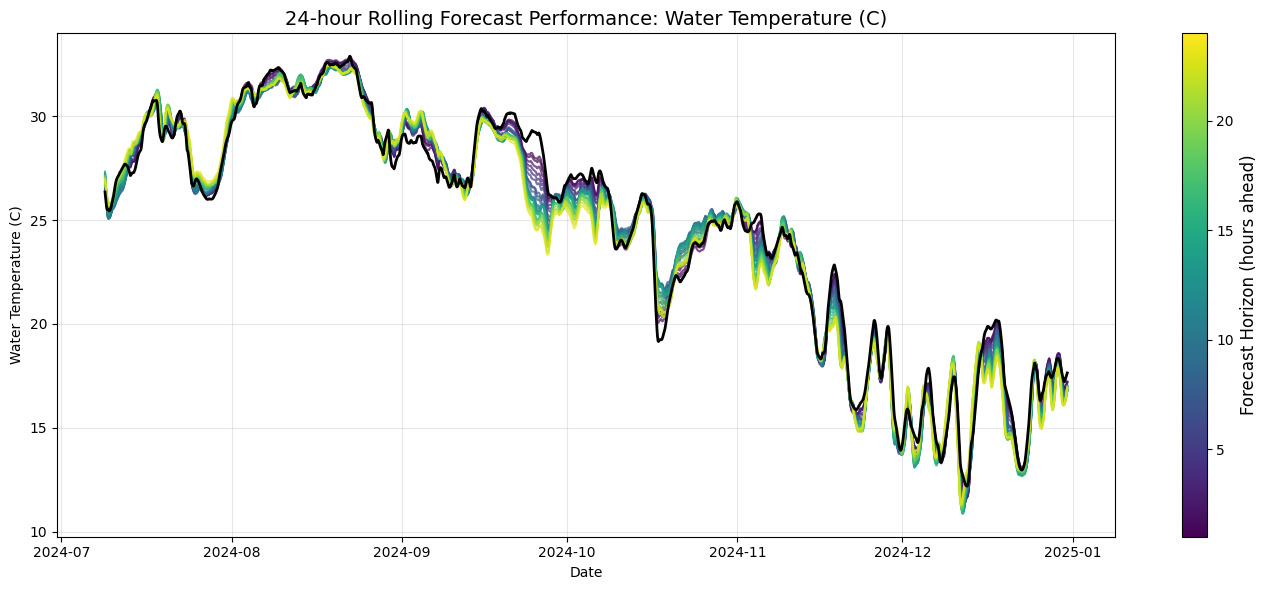

In [427]:
plot_all_predictions(temp_data)

In [430]:
from sklearn.metrics import r2_score
import pandas as pd

def compute_horizon_r2(res):
    """
    Compute R² for each forecast horizon (0–23 hours ahead).
    
    Parameters
    ----------
    res : dict containing:
        - res["test_preds"]: shape (N, 24)
        - res["test_truth"]: shape (N, 24)

    Returns
    -------
    pd.Series indexed 0..23 of R² values.
    """
    
    preds = res["test_preds"]      # (N, 24)
    truth = res["test_truth"]      # (N, 24)

    r2_values = {}

    for h in range(24):
        y_true = truth[:, h]
        y_pred = preds[:, h]

        # Remove NaN if any exist due to rolling or preprocessing
        mask = (~pd.isna(y_true)) & (~pd.isna(y_pred))
        if mask.sum() > 1:
            r2_values[h] = r2_score(y_true[mask], y_pred[mask])
        else:
            r2_values[h] = float("nan")

    return pd.Series(r2_values, name="R2_by_horizon")


In [455]:
def compare_r2_horizons(res_dict):
    """
    Given a dictionary of {name: res}, compute and plot horizon R² for each.

    Parameters
    ----------
    res_dict : dict
        Keys are model names / parameter settings
        Values are the corresponding `res` dictionaries (with test_preds/test_truth)

    Returns
    -------
    pd.DataFrame where rows=horizons and columns=each model's R²
    """
    
    # Compute R2 for each model
    results = {}
    for name, res in res_dict.items():
        results[name] = compute_horizon_r2(res)

    r2_df = pd.DataFrame(results)   # shape (24, num_models)

    # ---- Plot ----
    plt.figure(figsize=(12, 6))
    
    for name in r2_df.columns:
        plt.plot(r2_df.index+1, r2_df[name], label=name, linewidth=2)

    plt.xlabel("Forecast Horizon (hours ahead)")
    plt.ylabel("R²")
    plt.xticks(range(1,25))
    plt.title("R² Across Forecast Horizons for Multiple Models")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()
    
    return r2_df


In [431]:
compute_horizon_r2(temp_data)

0     0.992516
1     0.990252
2     0.986069
3     0.980349
4     0.973444
5     0.966692
6     0.959873
7     0.955081
8     0.949884
9     0.945427
10    0.941055
11    0.938865
12    0.936252
13    0.933542
14    0.932412
15    0.931772
16    0.929288
17    0.930182
18    0.929478
19    0.928545
20    0.926987
21    0.927000
22    0.924056
23    0.922436
Name: R2_by_horizon, dtype: float64

In [301]:
temp_data['metrics']

{'mae': 0.9771688580513,
 'rmse': 1.2892705202102661,
 'mse': 1.776875615119934,
 'r2': 0.947144091129303,
 'n_samples': 4225}

# Develop a model for each parameter

In [304]:
super_data = {}
for param in df.columns:
    print(f"Training model for parameter: {param}")
    model_res = train_model_for_target(df,
                                       target_col=param,
                                       input_len=168, # one week
                                       out_len=24, # one day
                                       batch_size=64,
                                       n_epochs=50,
                                       lr=1e-3,
                                       hidden_size=64,
                                       num_layers=2,
                                       device=None,
                                       verbose=True,
                                       patience=6)
    super_data[param] = model_res

Training model for parameter: Discharge (cfs)
Epoch 001 | train_loss=0.282056 | val_loss=5.021205
Epoch 002 | train_loss=0.198473 | val_loss=4.210611
Epoch 003 | train_loss=0.187453 | val_loss=3.822130
Epoch 004 | train_loss=0.177609 | val_loss=4.017594
Epoch 005 | train_loss=0.165898 | val_loss=3.689635
Epoch 006 | train_loss=0.148062 | val_loss=4.298532
Epoch 007 | train_loss=0.128856 | val_loss=3.714333
Epoch 008 | train_loss=0.120828 | val_loss=3.849335
Epoch 009 | train_loss=0.111003 | val_loss=4.069672
Epoch 010 | train_loss=0.109374 | val_loss=4.163248
Epoch 011 | train_loss=0.098456 | val_loss=4.360068
Early stopping after 11 epochs (patience=6). Best val_loss=3.689635
Test metrics: {'mae': 162.9937286376953, 'rmse': 567.0760498046875, 'mse': 350587.625, 'r2': 0.6915254592895508, 'n_samples': 4225}
Training model for parameter: Water Temperature (C)
Epoch 001 | train_loss=0.118256 | val_loss=0.045106
Epoch 002 | train_loss=0.042191 | val_loss=0.042068
Epoch 003 | train_loss=0.0

Results for parameter: Discharge (cfs)
{'mae': 162.9937286376953, 'rmse': 567.0760498046875, 'mse': 350587.625, 'r2': 0.6915254592895508, 'n_samples': 4225}
R2: -3.4583


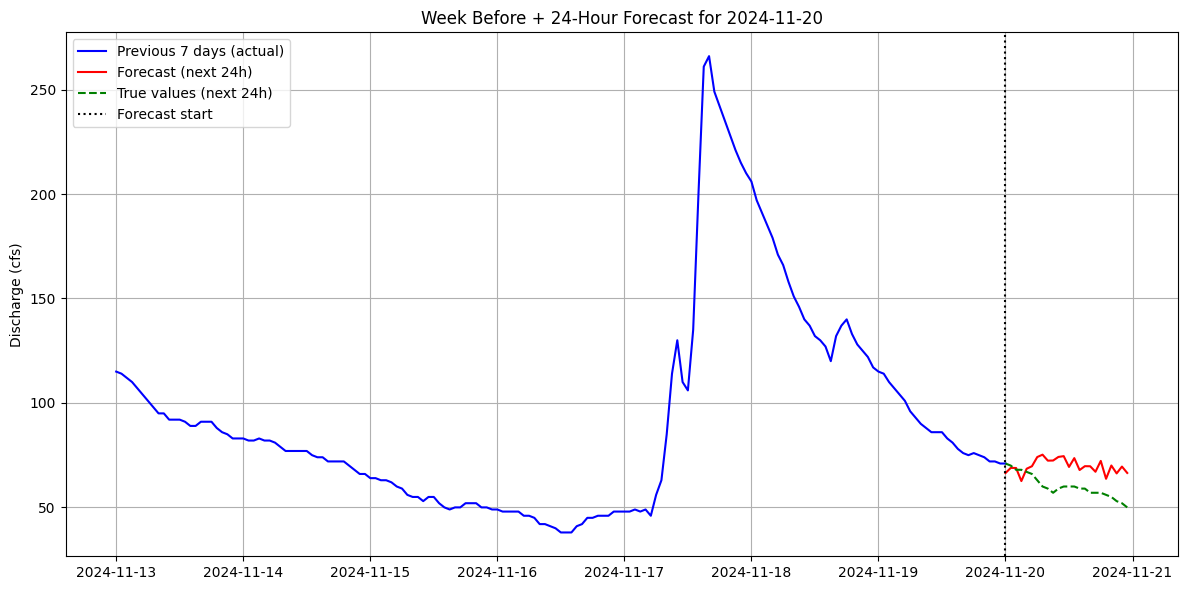

4225
Rolling R2: 0.9832


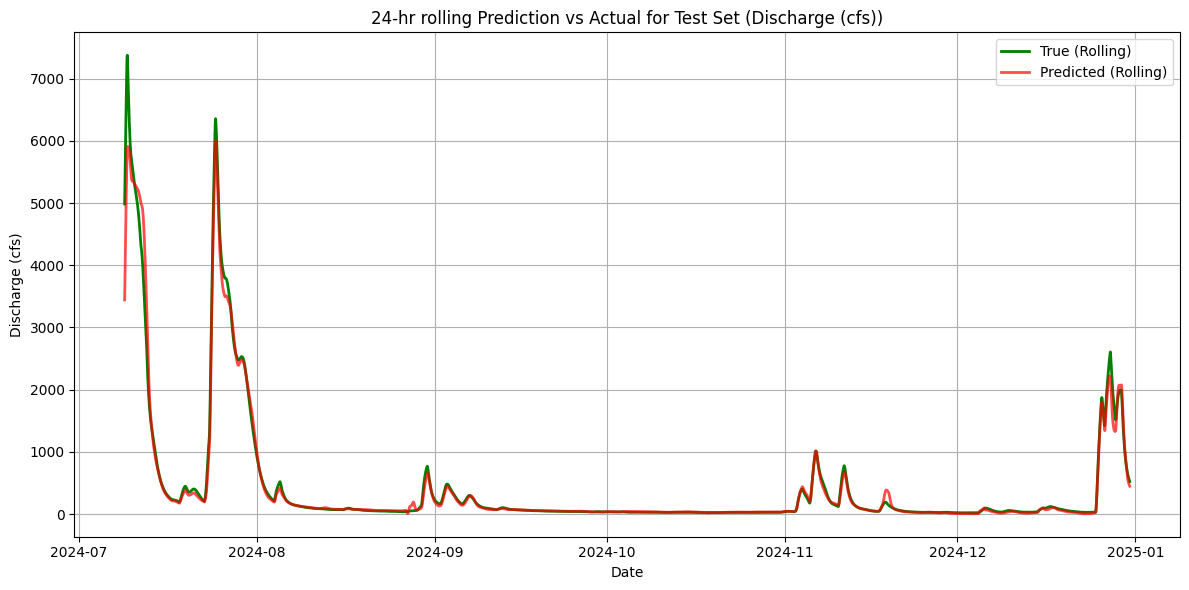

Results for parameter: Water Temperature (C)
{'mae': 0.8530110716819763, 'rmse': 1.1294435262680054, 'mse': 1.3587175607681274, 'r2': 0.9595834612846375, 'n_samples': 4225}
R2: 0.5533


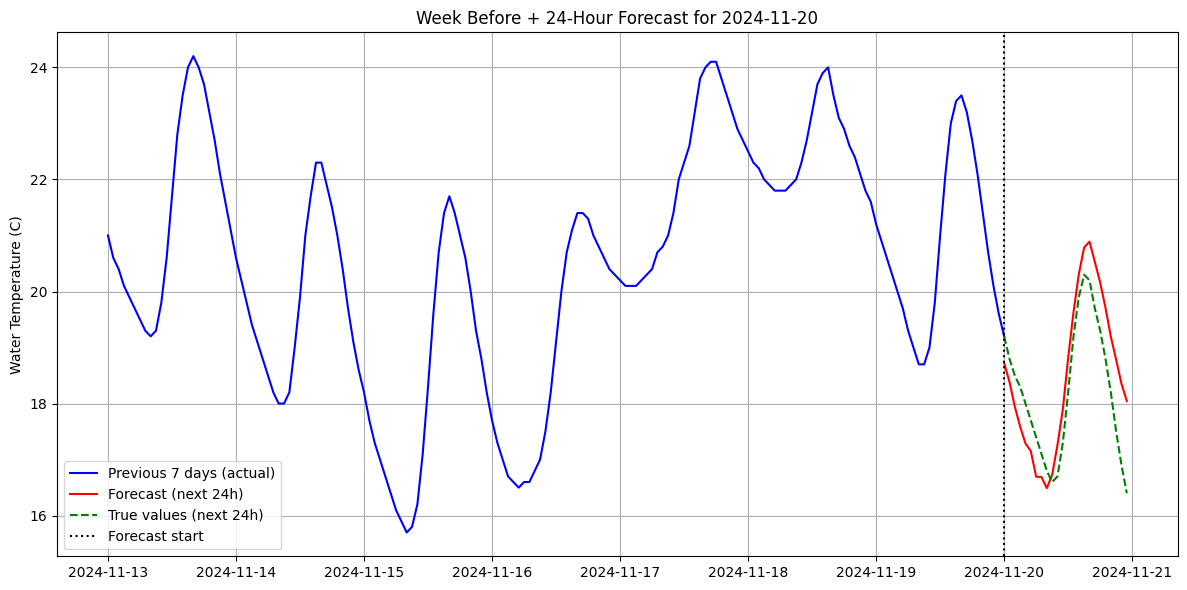

4225
Rolling R2: 0.9972


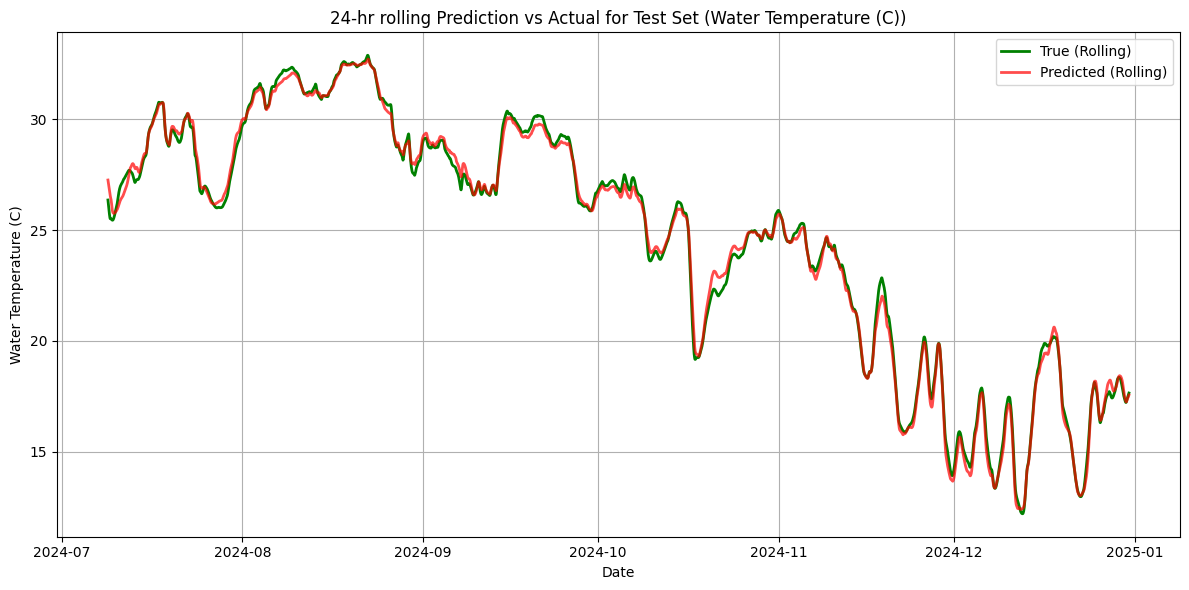

Results for parameter: pH (std units)
{'mae': 0.09043323993682861, 'rmse': 0.13551533222198486, 'mse': 0.018599597737193108, 'r2': 0.9082004427909851, 'n_samples': 4225}
R2: 0.0646


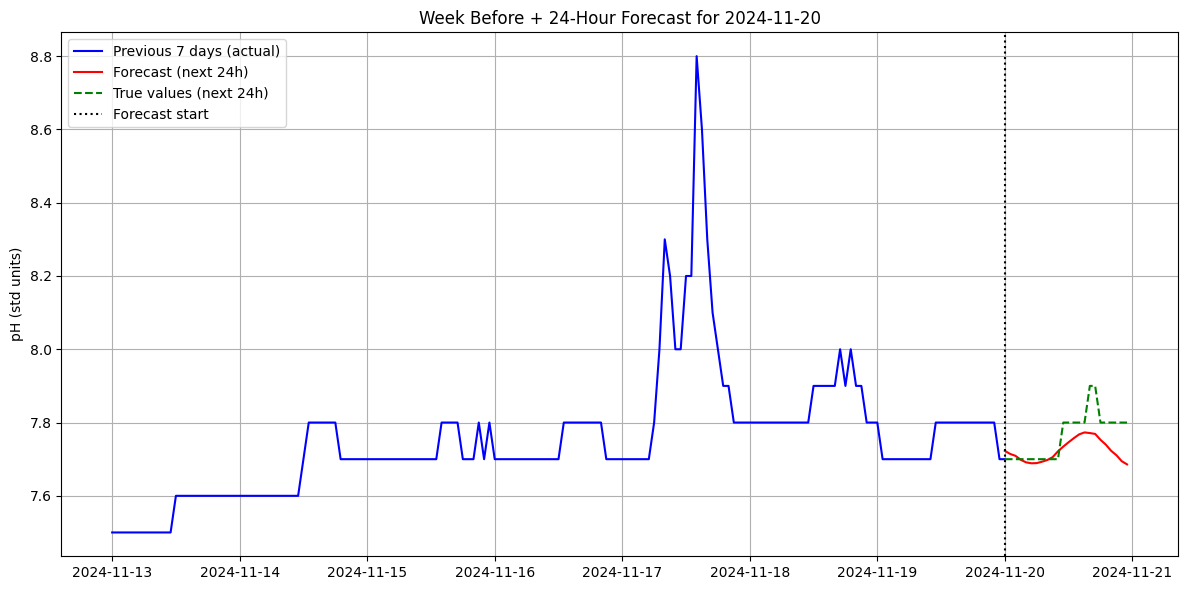

4225
Rolling R2: 0.9839


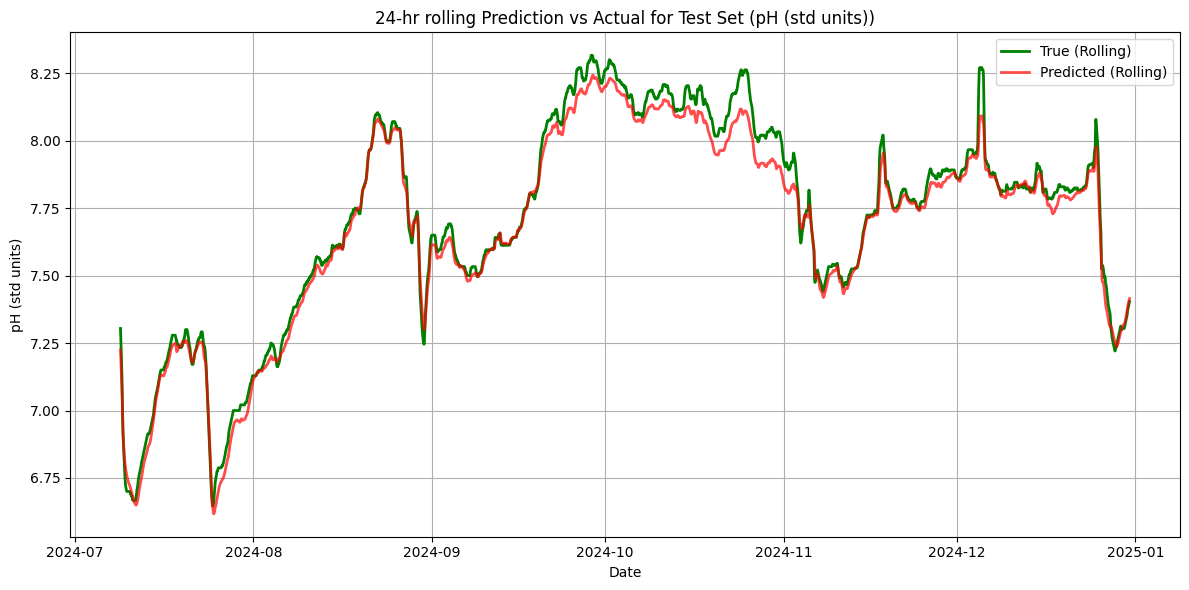

Results for parameter: Dissolved Oxygen (mg/L)
{'mae': 0.3195782005786896, 'rmse': 0.4432637691497803, 'mse': 0.20386767387390137, 'r2': 0.9297987818717957, 'n_samples': 4225}
R2: -0.6892


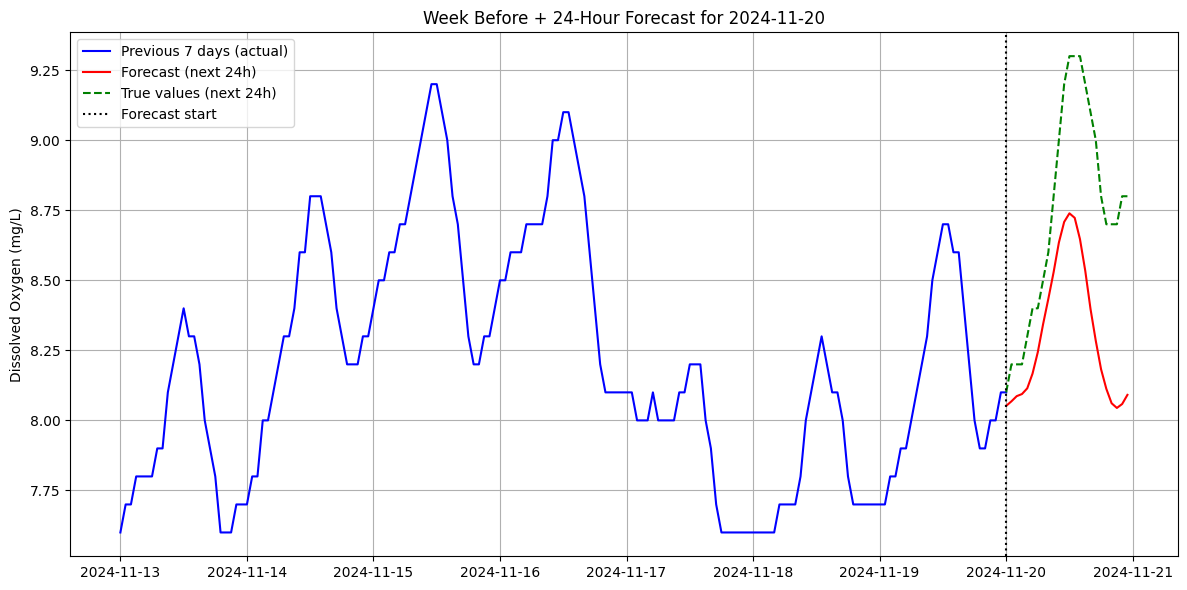

4225
Rolling R2: 0.9909


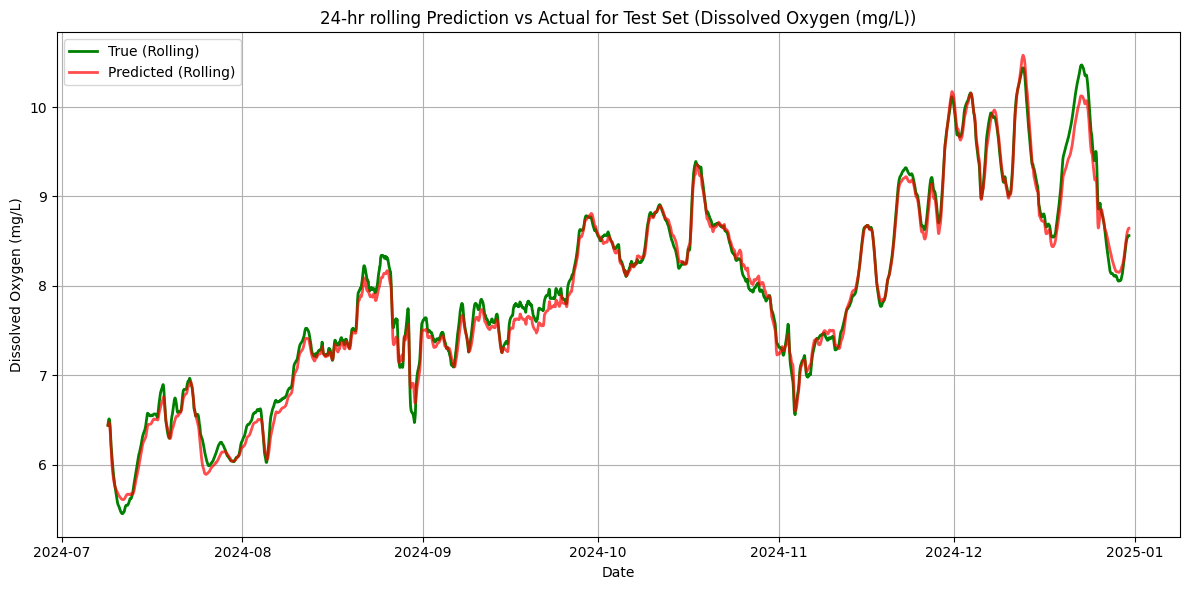

Results for parameter: Specific Conductance (uS/cm)
{'mae': 26.661109924316406, 'rmse': 42.7743034362793, 'mse': 1956.6322021484375, 'r2': 0.9462494254112244, 'n_samples': 4225}
R2: -2.3242


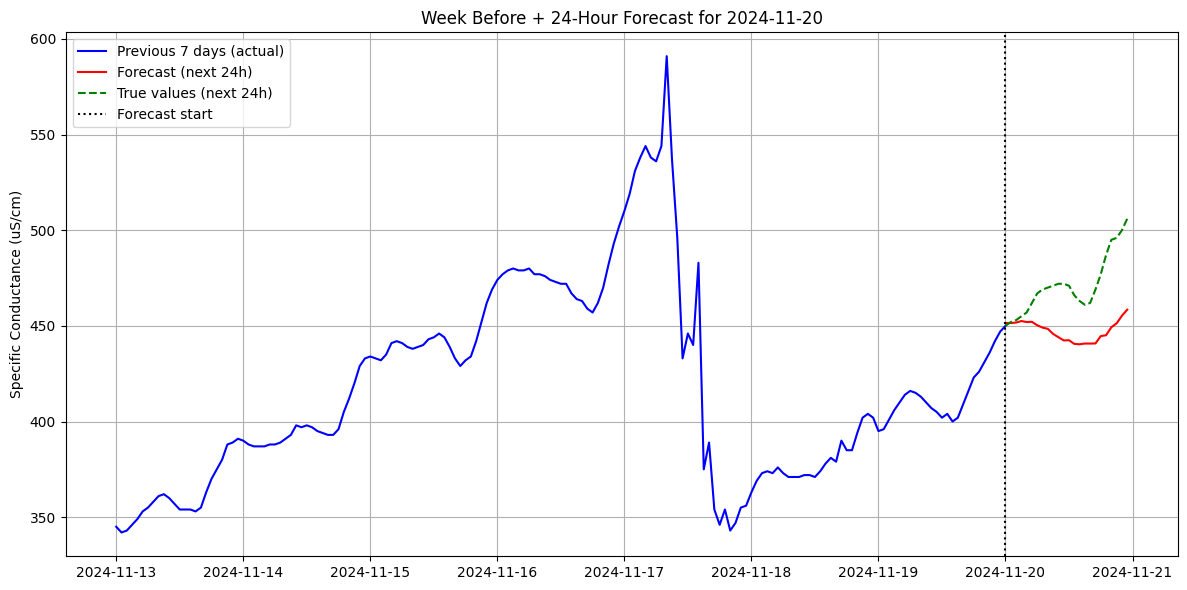

4225
Rolling R2: 0.9963


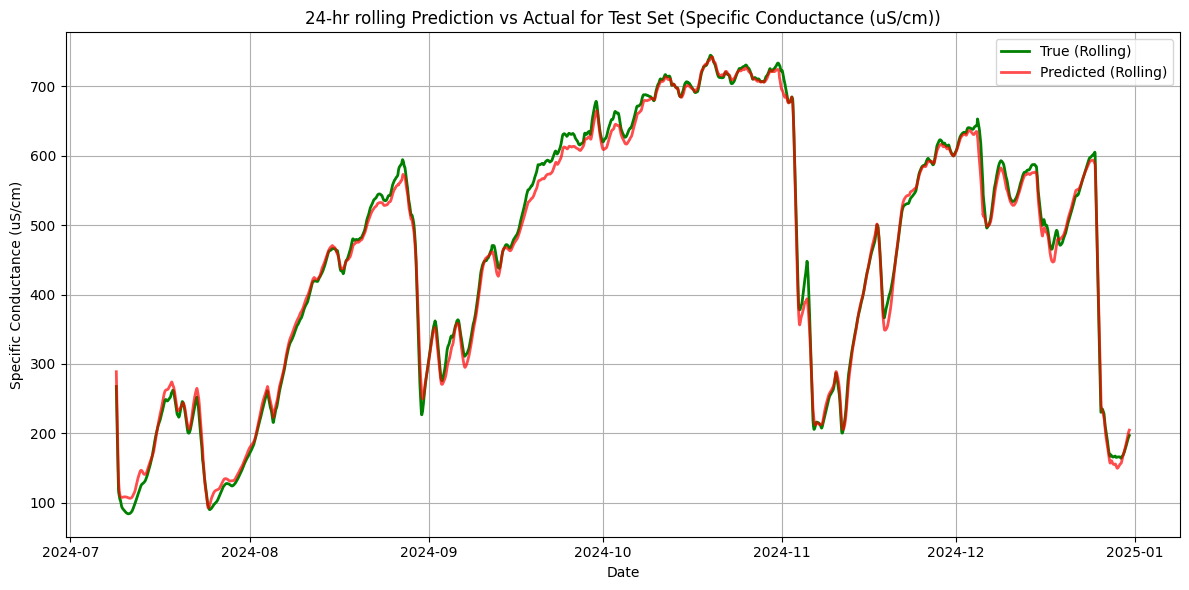

Results for parameter: Turbidity (NTU)
{'mae': 13.11662769317627, 'rmse': 27.45229148864746, 'mse': 785.63671875, 'r2': 0.6066176295280457, 'n_samples': 4225}
R2: -0.6125


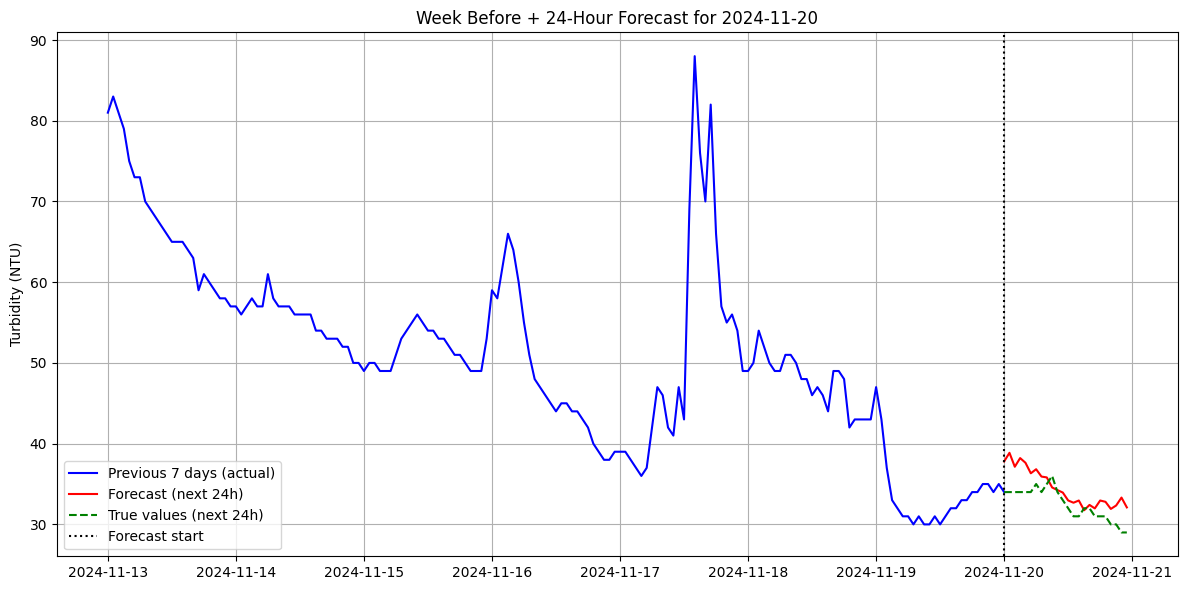

4225
Rolling R2: 0.9731


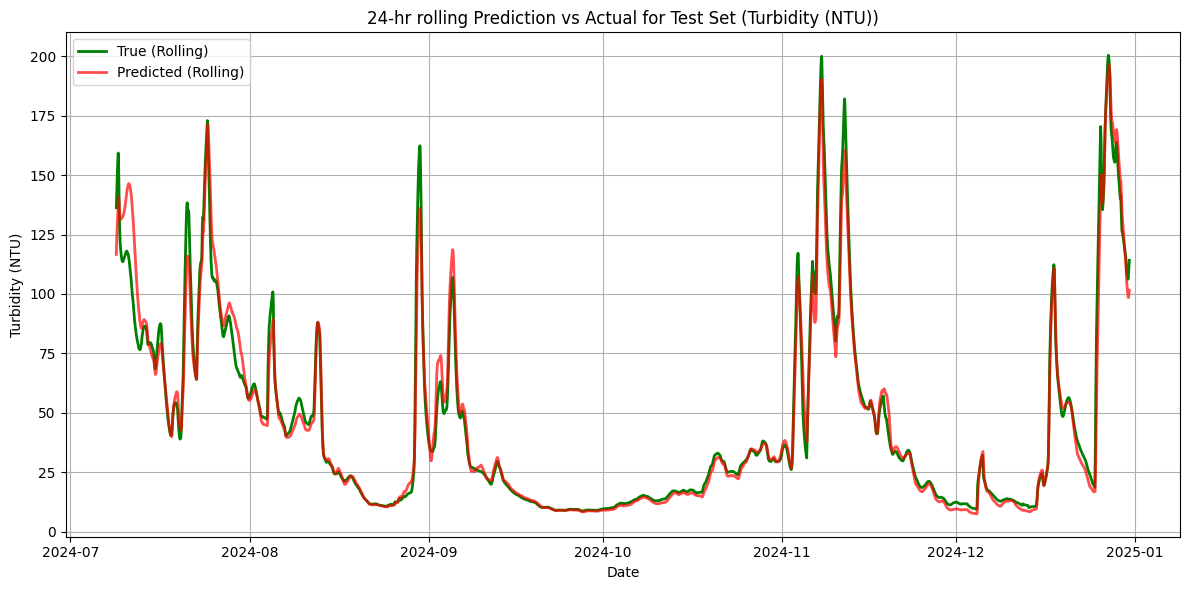

Results for parameter: Total Organic Carbon (mg/L)
{'mae': 0.5517246723175049, 'rmse': 0.9637975692749023, 'mse': 0.9778463244438171, 'r2': 0.793801486492157, 'n_samples': 4225}
R2: 0.0000


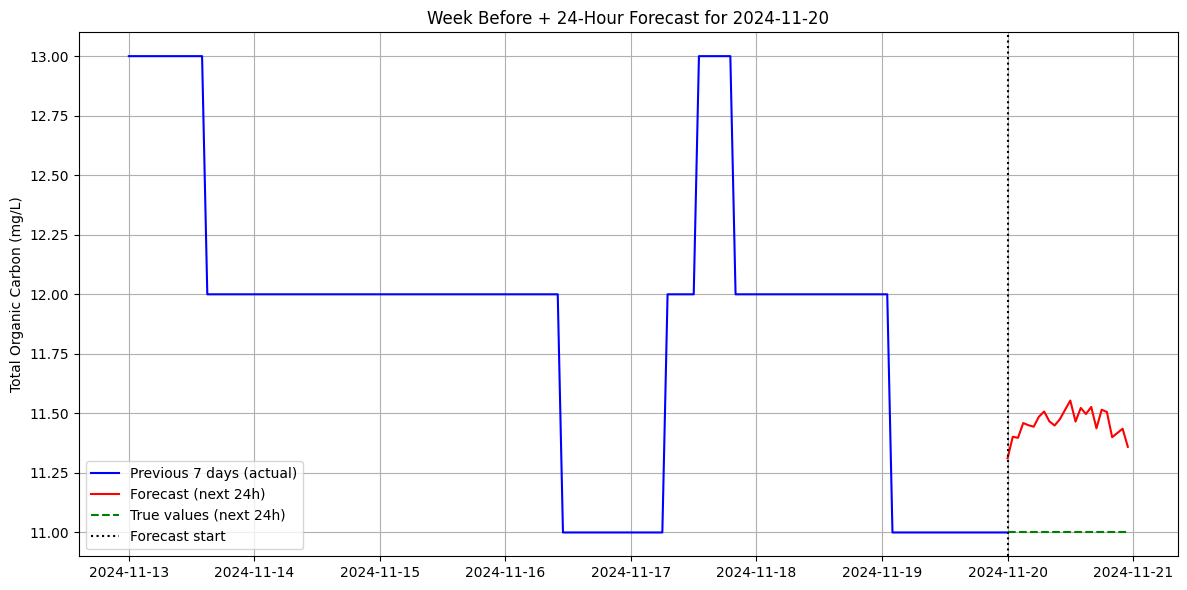

4225
Rolling R2: 0.9901


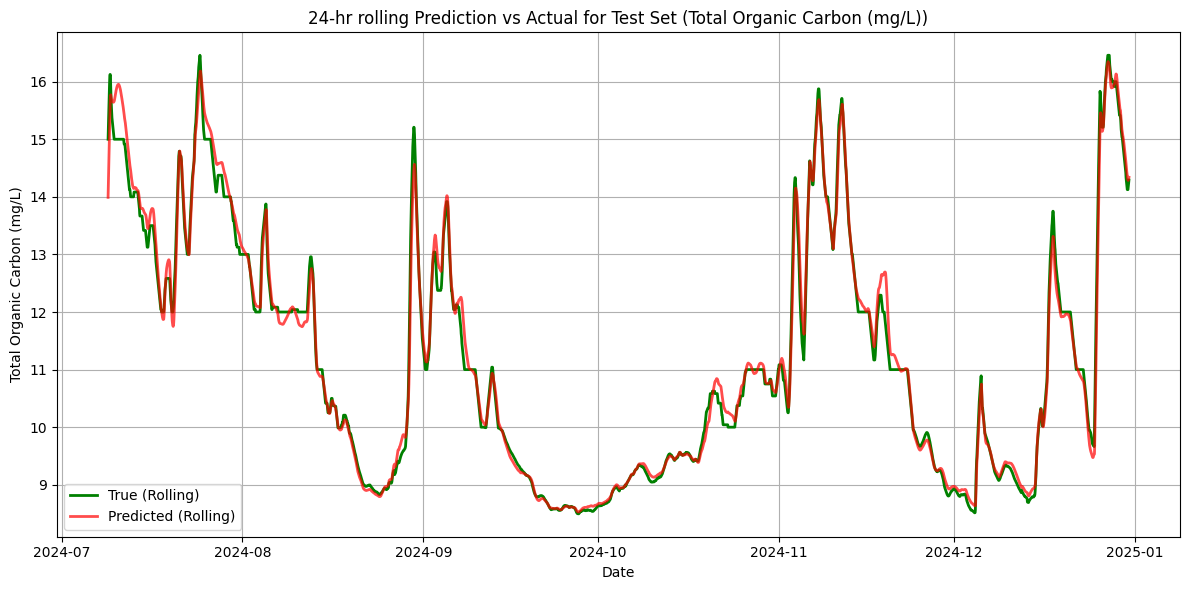

Results for parameter: Nitrate + Nitrite (mg/L)
{'mae': 0.3605906665325165, 'rmse': 0.6312682032585144, 'mse': 0.4305994510650635, 'r2': 0.9203378558158875, 'n_samples': 4225}
R2: -4.2344


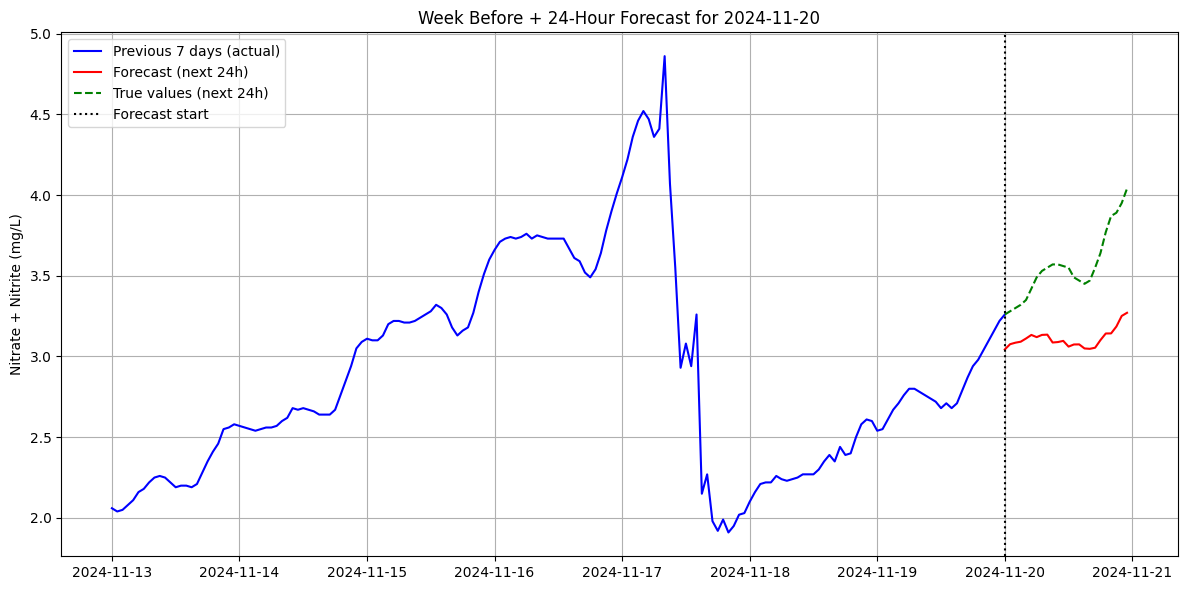

4225
Rolling R2: 0.9949


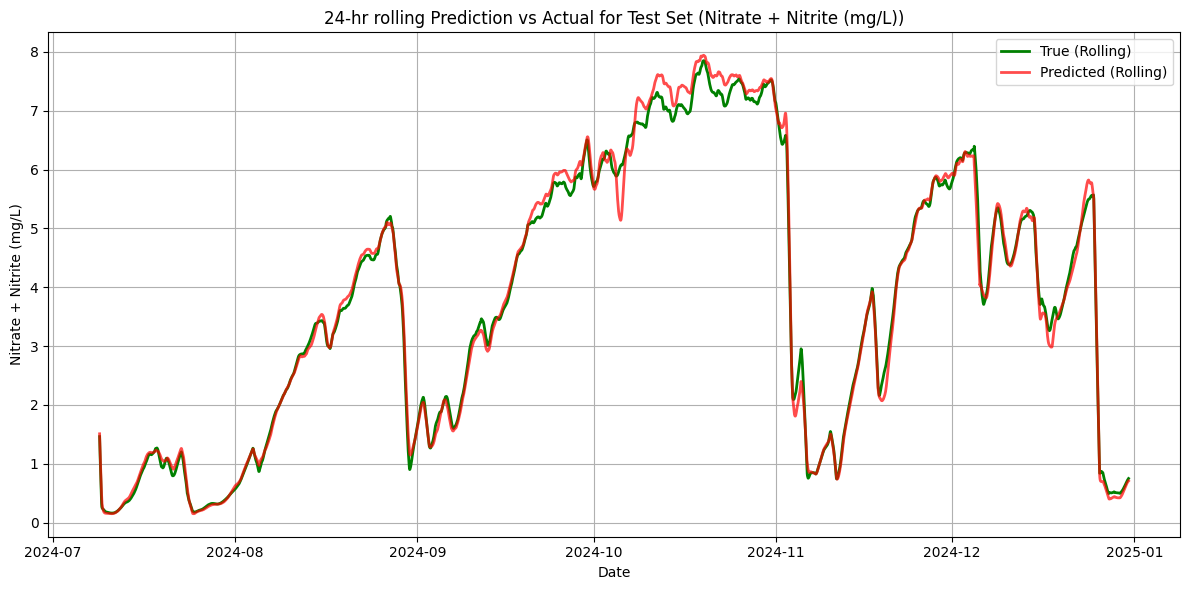

Results for parameter: Total Phosphorus (mg/L)
{'mae': 0.0786544680595398, 'rmse': 0.11851391196250916, 'mse': 0.014733891002833843, 'r2': 0.9281458854675293, 'n_samples': 4225}
R2: -21.0535


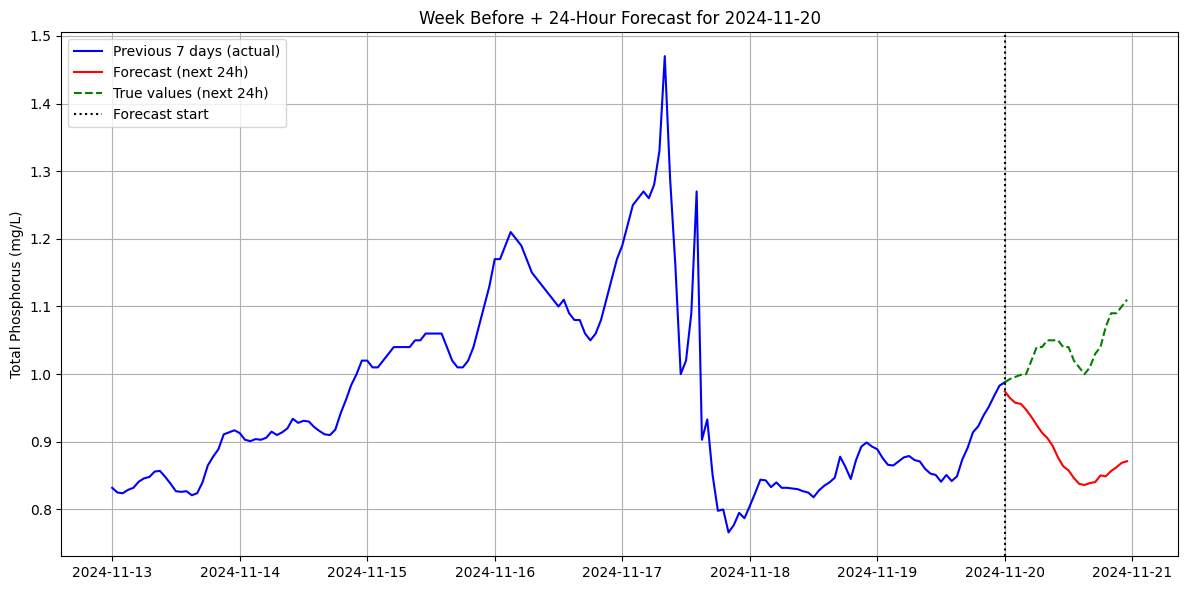

4225
Rolling R2: 0.9962


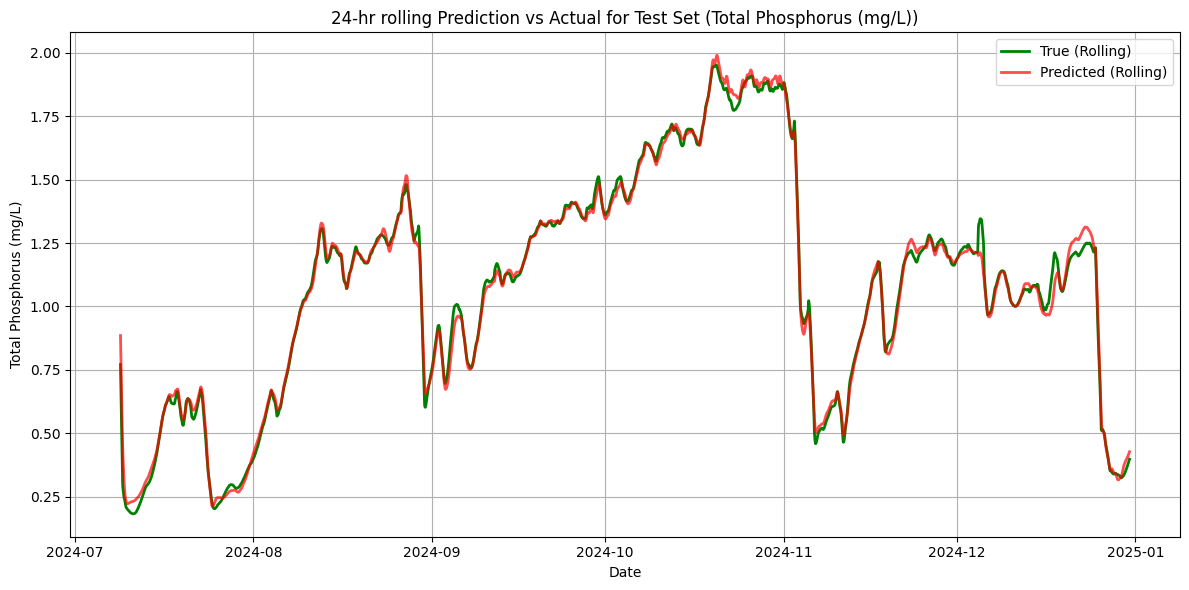

Results for parameter: Precipitation 1hr (in)
{'mae': 0.06901910901069641, 'rmse': 0.367177277803421, 'mse': 0.13551507890224457, 'r2': 0.023744849488139153, 'n_samples': 4225}
R2: 0.0000


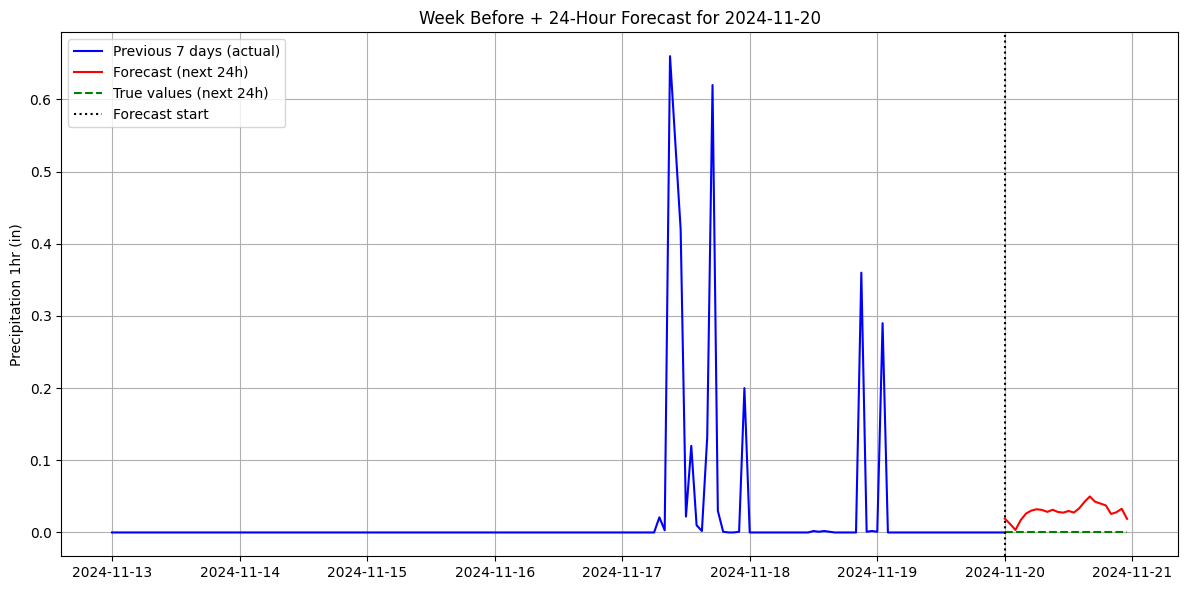

4225
Rolling R2: 0.6578


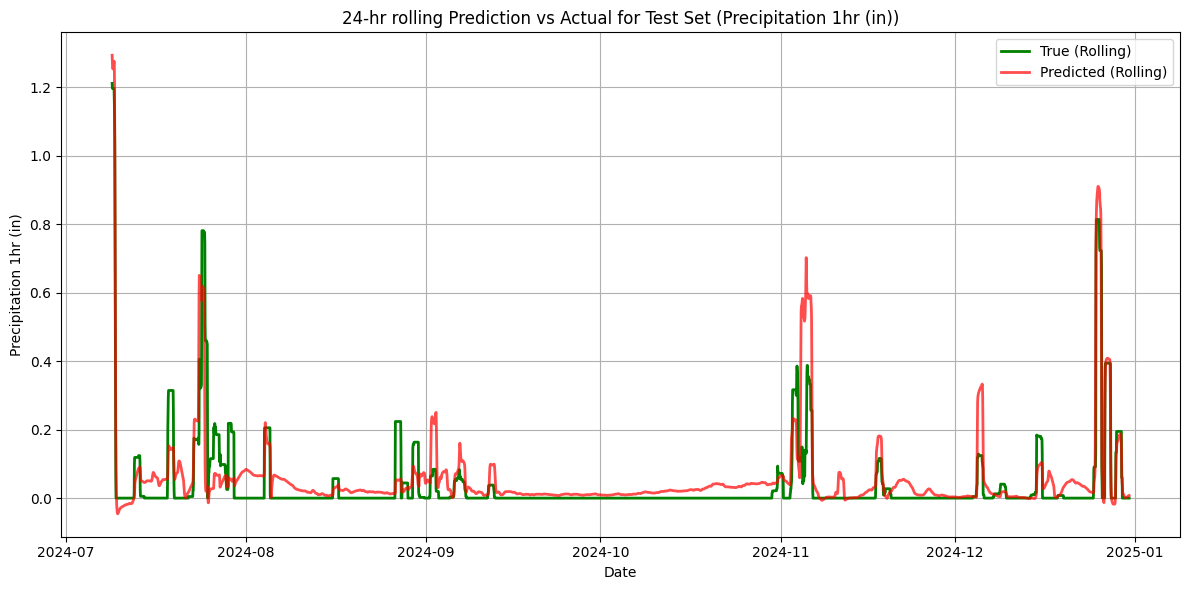

In [374]:
for param, res in super_data.items():
    print(f"Results for parameter: {param}")
    print(res['metrics'])
    res['full_df'] = df
    plot_week_window(res, "2024-11-20")
    plot_test_daily(res)

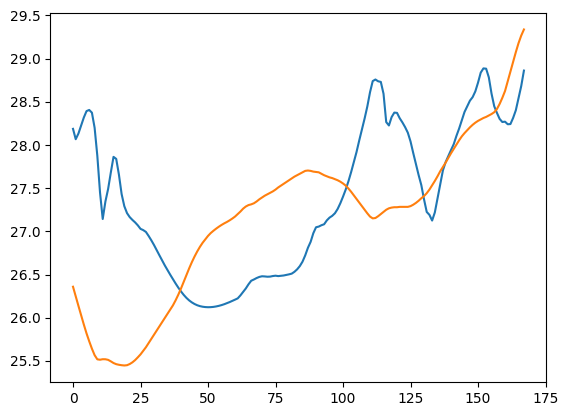

In [306]:
plt.plot(super_data['Water Temperature (C)']['test_preds'].mean(axis=1)[0:168])
plt.plot(super_data['Water Temperature (C)']['test_truth'].mean(axis=1)[0:168])

## Compare each parameter

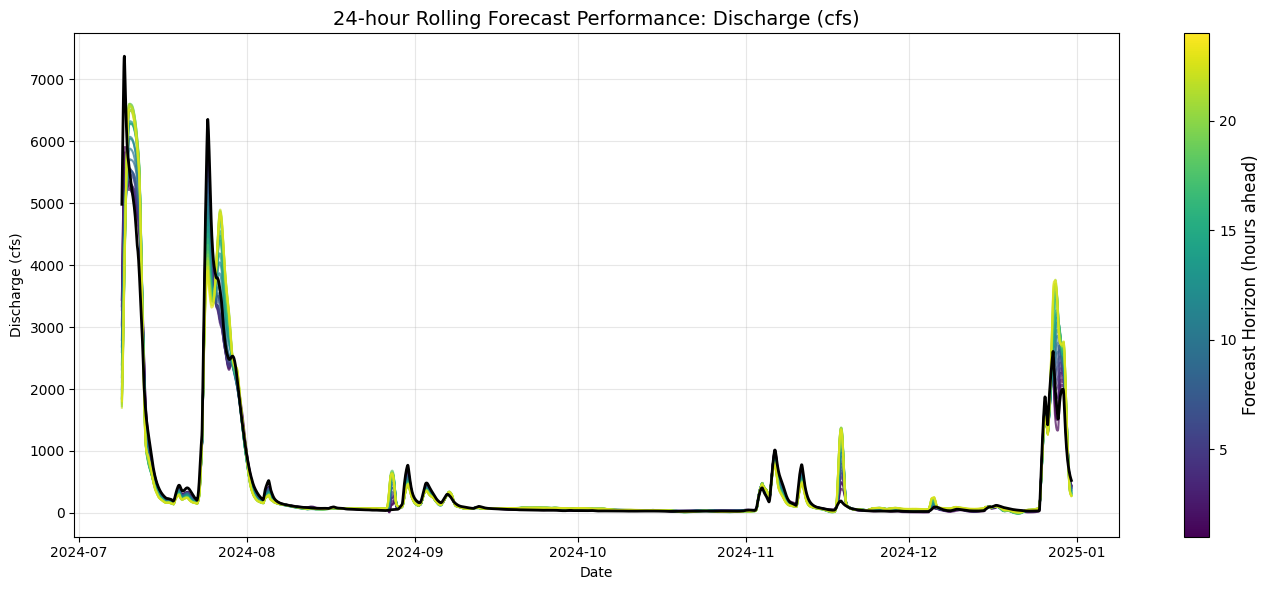

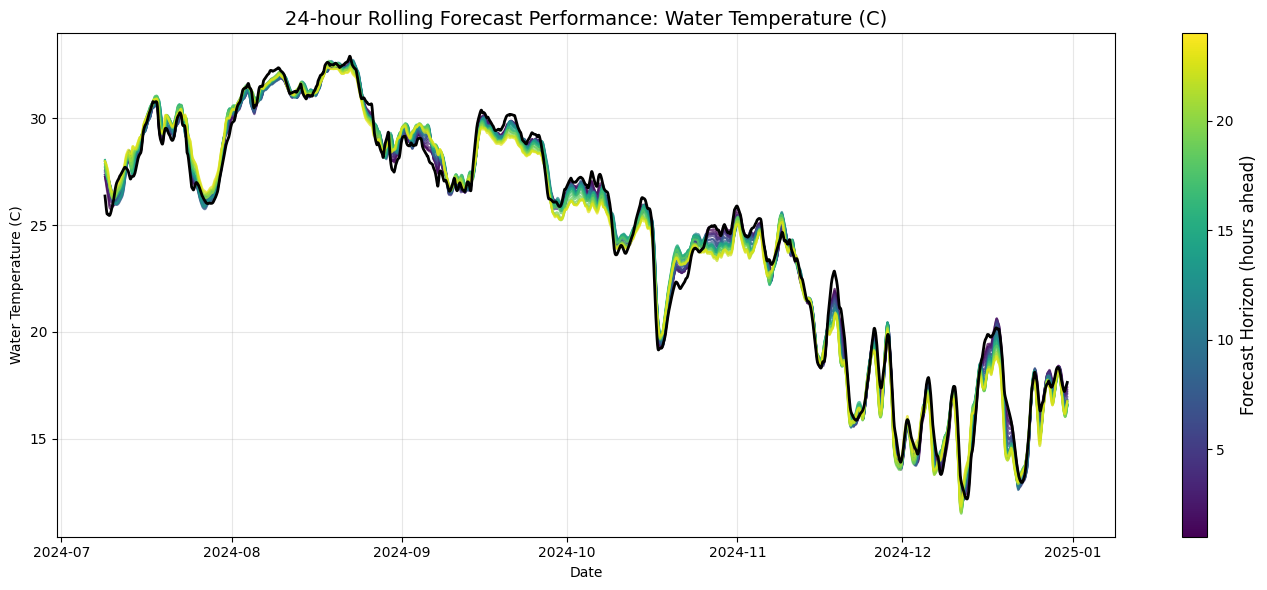

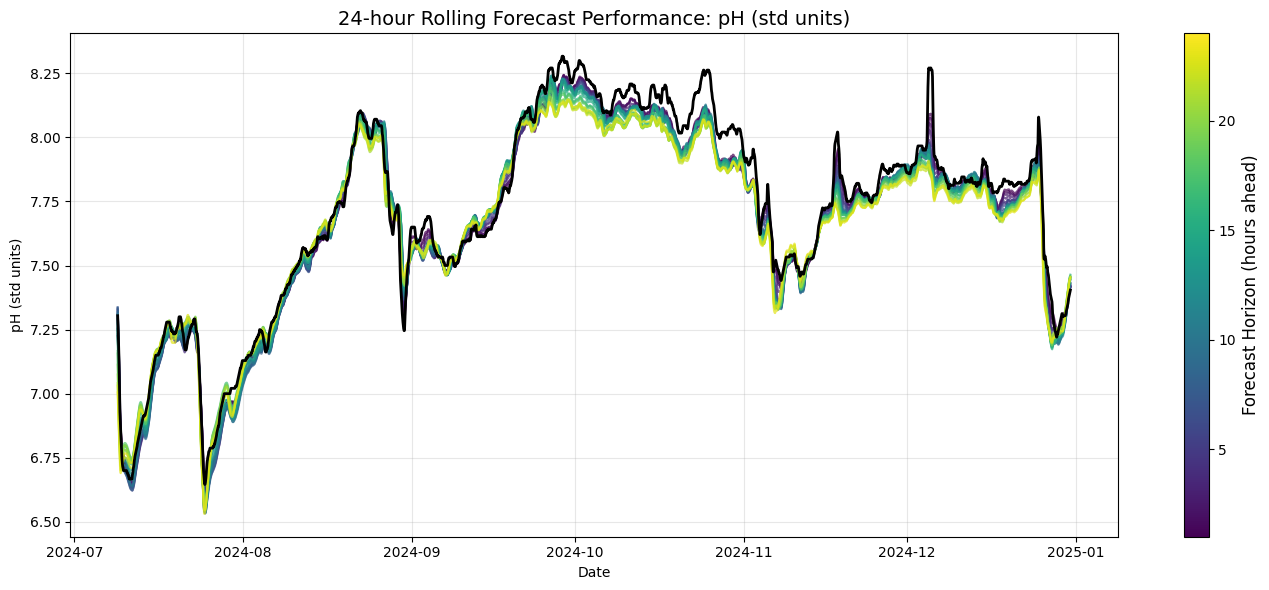

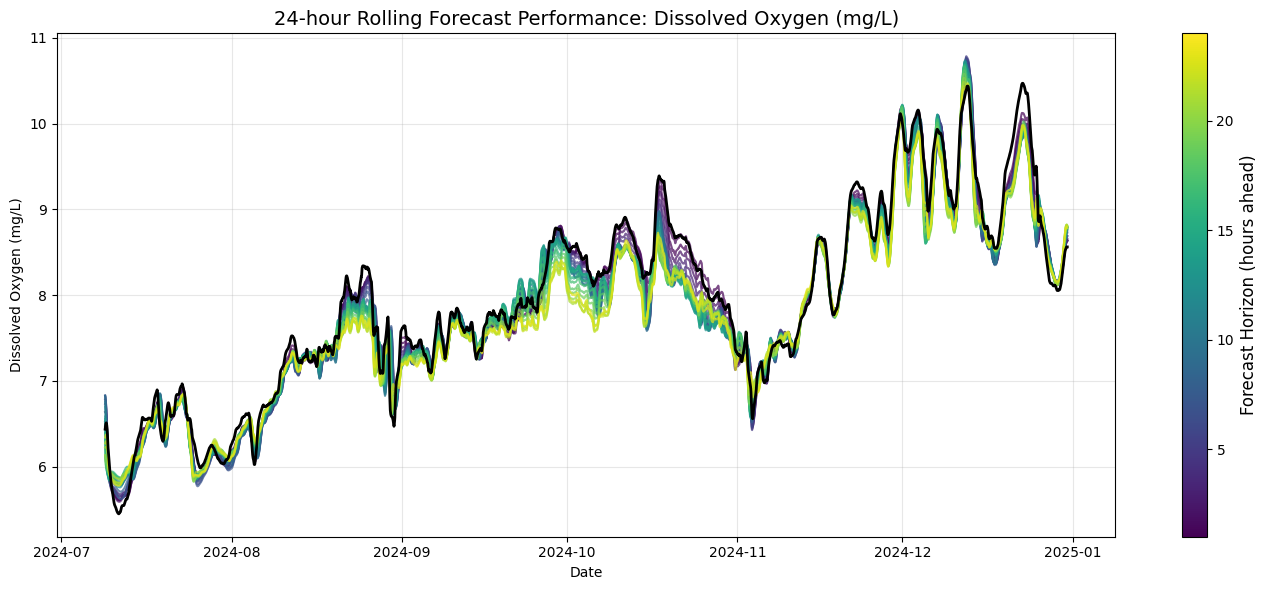

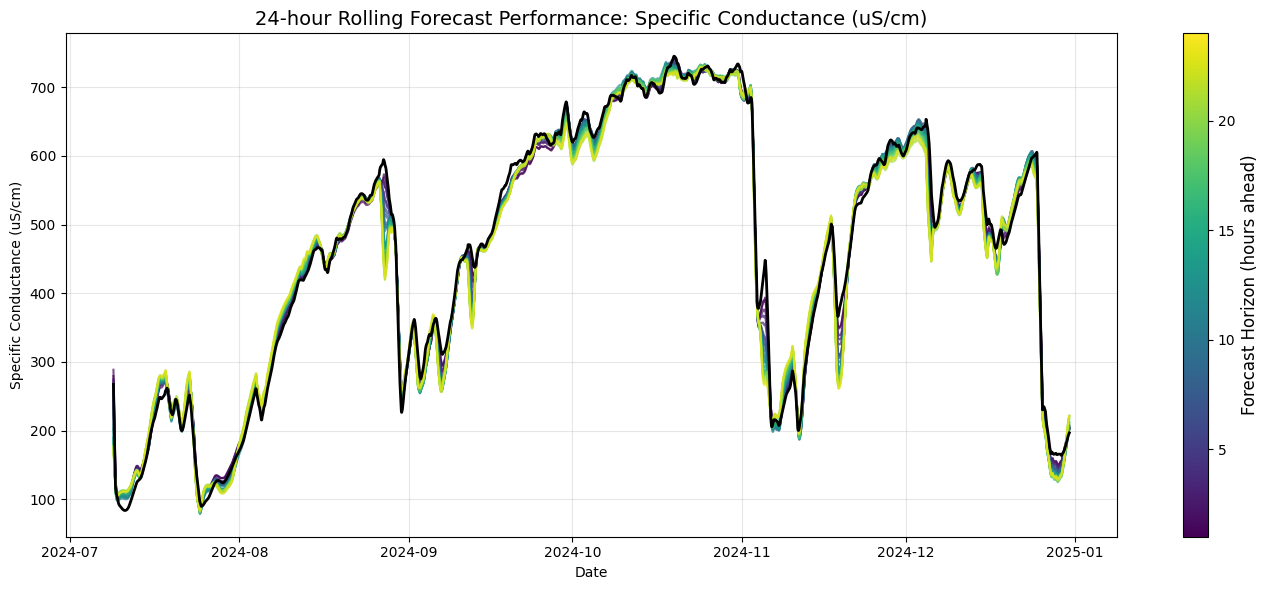

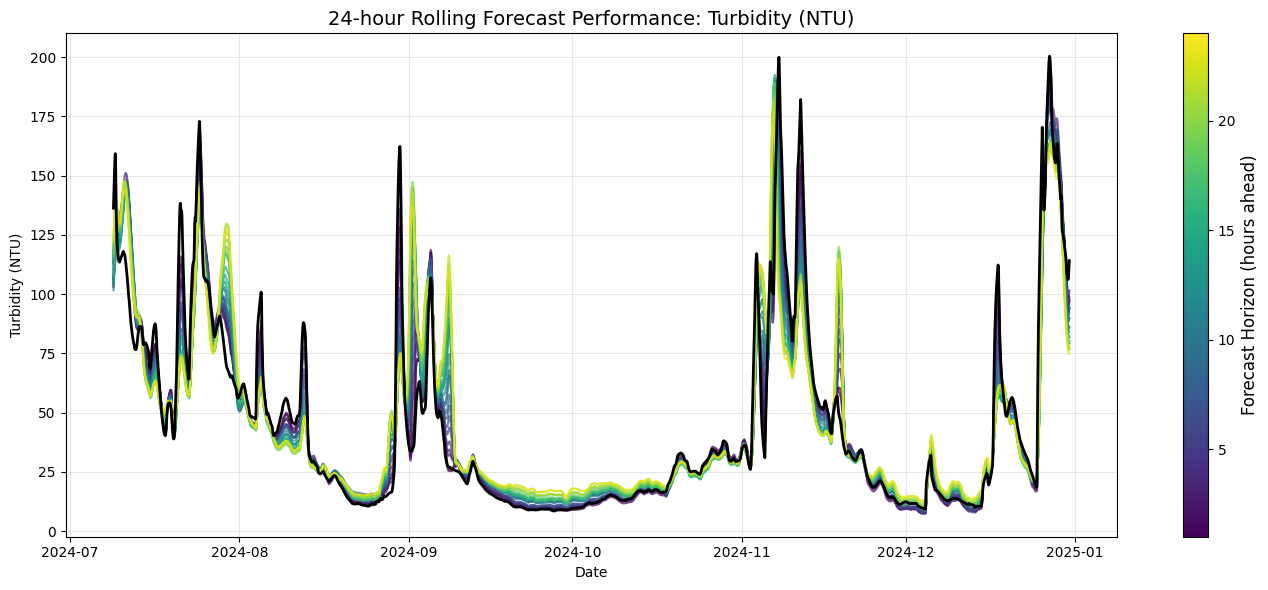

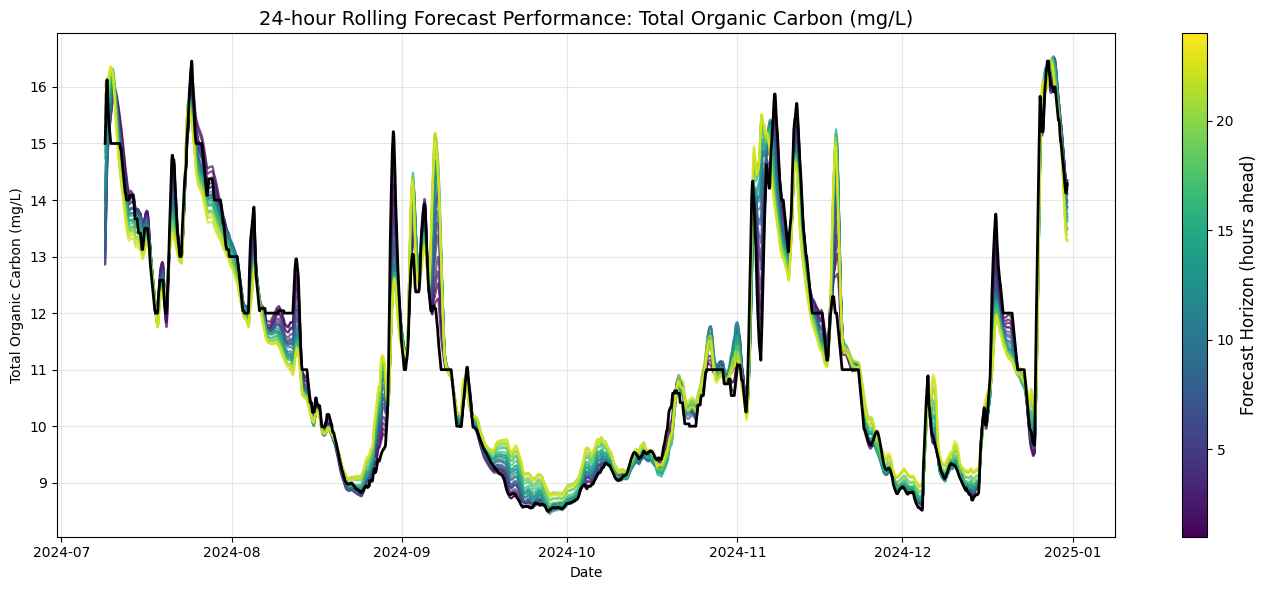

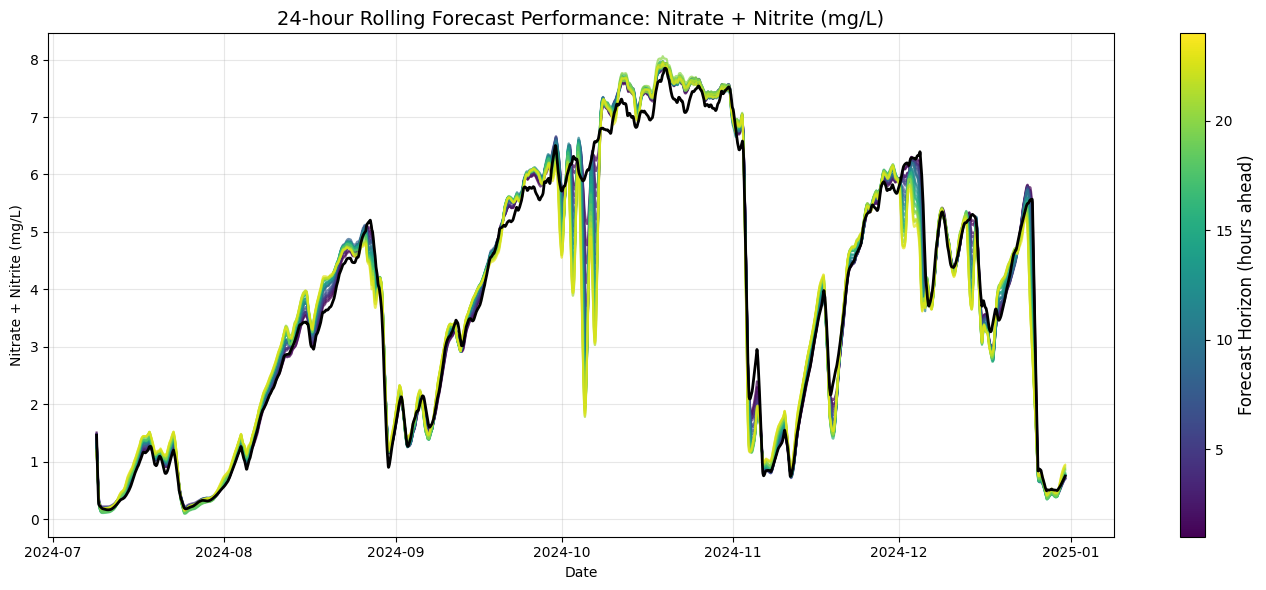

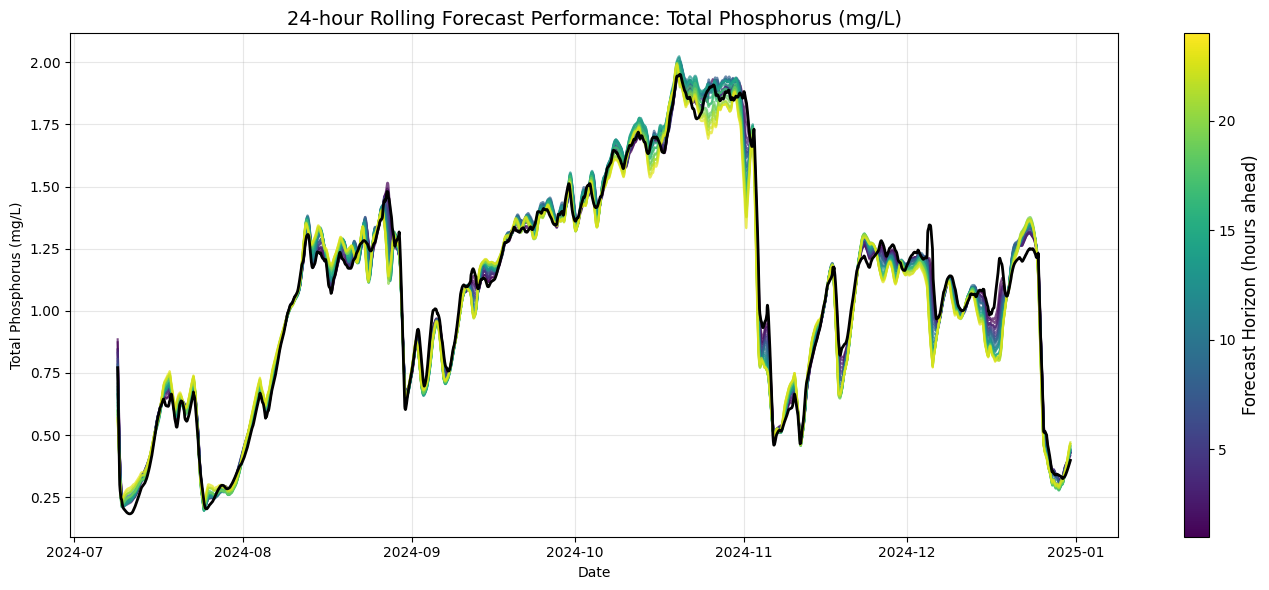

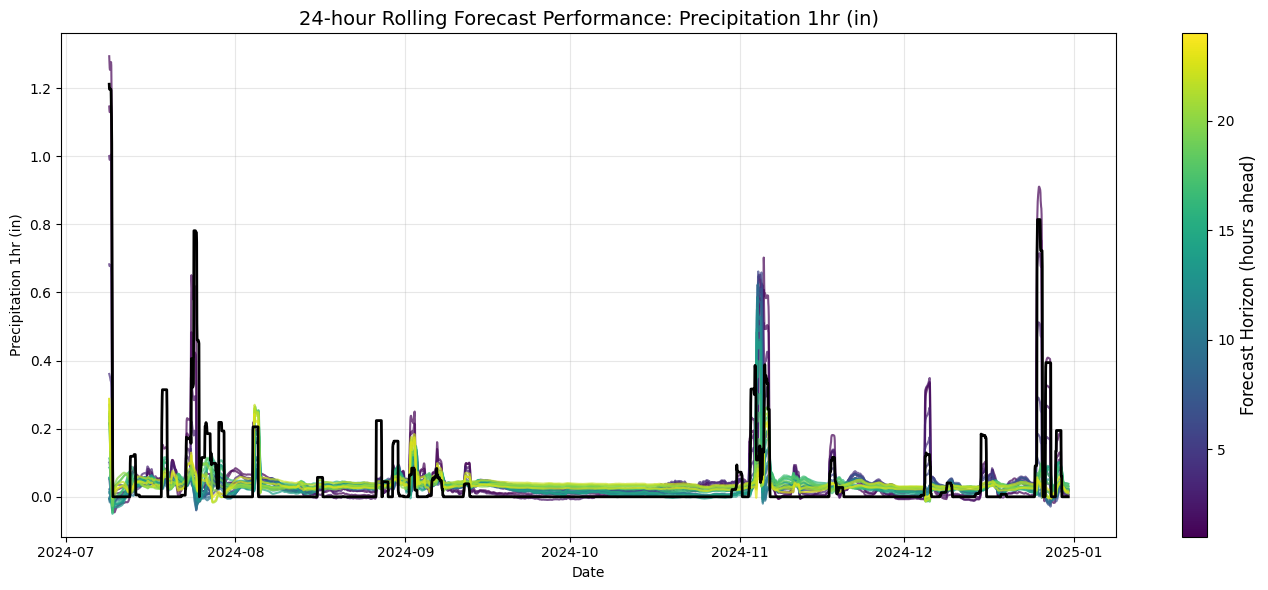

In [428]:
for param_data in super_data.values():
    plot_all_predictions(param_data) 

# Compare Params

C:\Users\epzausch\AppData\Local\Temp\ipykernel_12064\2180593228.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(r2s.keys(),rotation=90)


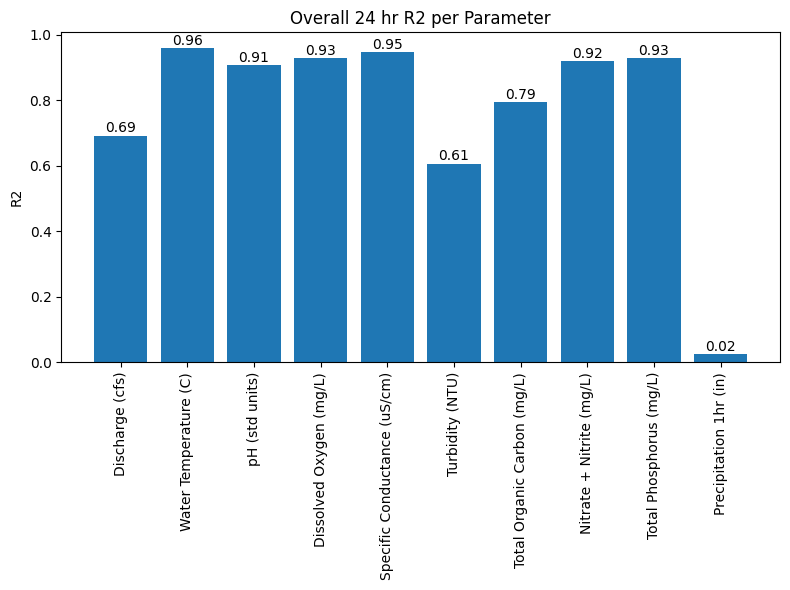

In [449]:
# This shows the average across the 24 hr window
fig,ax = plt.subplots(figsize=(8,6))


r2s = {}
for param, res in super_data.items():
    # print(f"Results for parameter: {param}")
    # print(res['metrics'])
    
    r2s[param] = res['metrics']['r2']

ax.bar(r2s.keys(), r2s.values())
ax.set_title("Overall 24 hr R2 per Parameter")
ax.set_xticklabels(r2s.keys(),rotation=90)

for i in range(len(r2s)):
    ax.text(i, r2s[list(r2s.keys())[i]] + 0.01, f"{r2s[list(r2s.keys())[i]]:.2f}", ha='center')

ax.set_ylabel("R2")
plt.tight_layout()
plt.show()

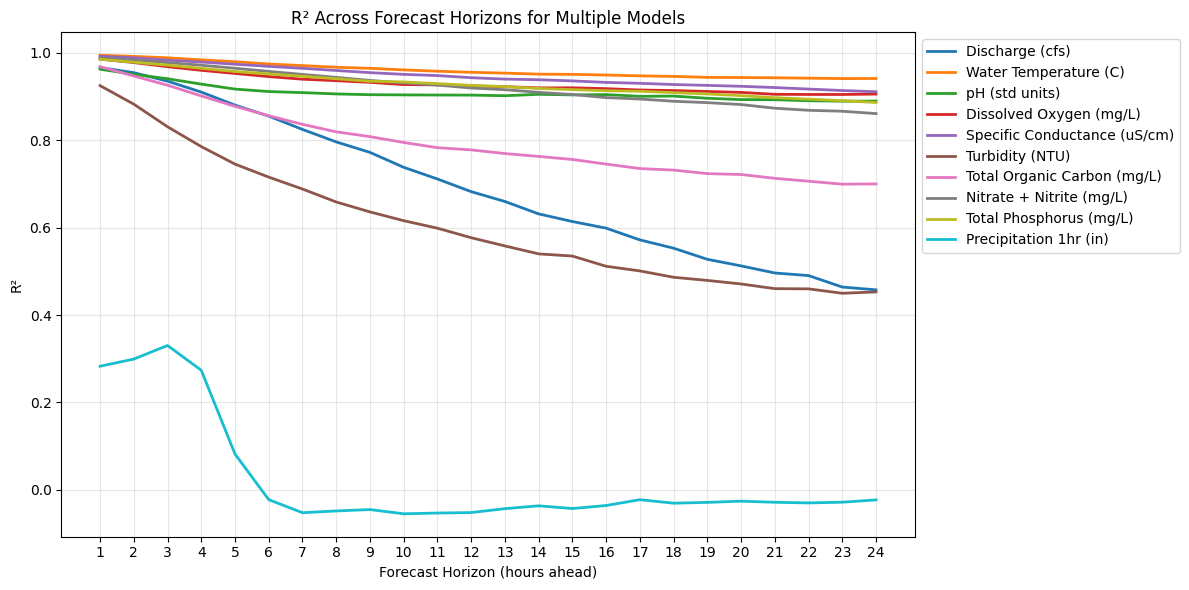

In [456]:
r2_horizon = compare_r2_horizons(super_data)

<Axes: >

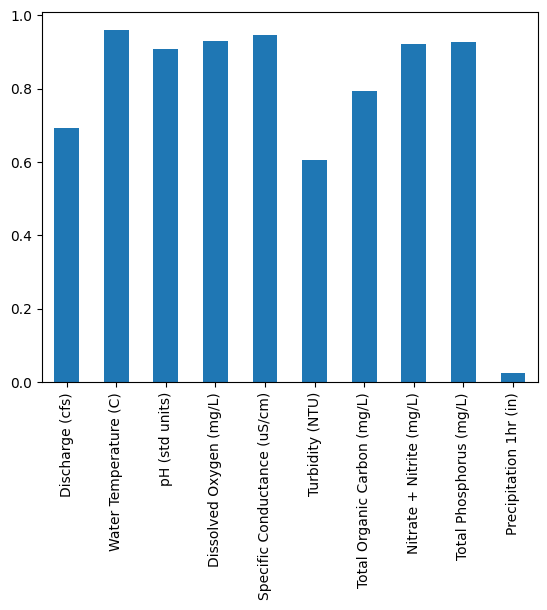

In [ ]:
r2_horizon.mean().plot(kind='bar') # 

# TODO:
### Create rolling window statistics
df1['rolling_mean_24'] = df1['value'].rolling(window=24).mean()
df1['rolling_std_24'] = df1['value'].rolling(window=24).std()

### Remove rows with NaN values due to lagging/rolling
df1.dropna(inplace=True)


## Then can predict a mean and a std to give a range for every day